# TMA4320 Introduksjon til vitenskapelige beregninger - vår 2022
Laget av Albert bayazidi, Abinida Jeyarajah, Synne Gilbu  

### Prosjekt 2 - Teknisk fysikk
### En modellering av skipsdynamikk og numerisk analyse

## Innledning  
Skip er konstruksjoner som er svært interessante å studere fysisk. Skal man se på et skips dynamikk og stabilitet så er det svært mange faktorer som spiller inn. 

I dette prosjektet skal vi ta for oss et halvsirkelformet skip. Vi vil bruke ulike numeriske metoder for å analysere både dynamikk og stabilitet. Her kommer Euler og Runge-Kutta 4 til å være sentrale. 

Vi vil i starten se på et ganske forenklet scenario der vi neglisjerer både bevegelsen til skipets massesenter og at mengden fortrengt vann er konstant. Senere vil vi implementere disse to faktorene. I tillegg vil vi introdusere en last som også vil ha en påvirkning på både skipets dynamikk og stabilitet. 

Denne lasten vil vi gi ulike egenskaper underveis. Helt til slutt vil vi i tillegg implementere en ny metode for å løse differensialligninger numerisk, Bogacki-Shampine. Her vil vi også inkludere friksjonskraften mellom lasten og skipet. Vi vil undersøke hvordan denne kraften vil ha noe å si for skipets stabilitet. 


In [1]:
import numpy as np #numpybibliotek 
from numpy.linalg import solve, norm #For å beregne lineære systemer og normer
import matplotlib.pyplot as plt #importerer matplot (for plotting av funksjoner)
from scipy.optimize import curve_fit #finne stigningstall til en kurve 
import time #for å måle tiden
from prettytable import PrettyTable #lage fine tabeller

Definerer parametre:

In [2]:
g = 9.81 #tyngdeakselerasjon
sigma0 = 1000 #massetettheten til vann per flateenhet 
sigma = 500 #massetettheten til skipet per flateenhet  
R = 10 #skipets radius 
A0 = 1/2*R**2*(sigma*np.pi/sigma0) #fortrengt vann ved likevekt 
Fb = sigma0*A0*g #oppdriften
As = (1/2)*np.pi*(R**2) #skipets tverrsnitt 
m = As * sigma #skipets masse per lengdeenhet 
Ic = (1/2)*m*(R**2)*(1- 32/(9*(np.pi**2))) #skipets treghetsmoment 
h = 4*R/(3*np.pi) #høydeforskjellen mellom metasenteret og massesenteret

Et skips dynamikk kan beskrives ved hjelp av en mengde fysiske prinsipper. Disse prinsippene kan videre gi oss en differensialligning. Denne kan igjen løses numerisk ved hjelp av ulike metoder som f.eks. Euler og Runge-Kutta 4. I denne delen vil vi demonstrere bruk av nettopp disse metodene. 

I utregningen nedenfor vil vi for enkelhets skyld neglisjere bevegelsen til skipets massesenter. I tillegg vil vi anta at mengden fortrengt vann er konstant.

Vi er interessert i å finne vinkelen som oppstår fra metasenteret til vannoverflaten. Videre ønsker vi å finne denne vinkelen slik at vi kan finne posisjonen til ulike punkter på skipet og dermed vite hvilken tilstand skipet befinner seg i. Vi har at $\beta = \frac{\sigma\pi}{\sigma_0} + sin(\beta) \label{eq1}\tag{1}$ Det finnes flere metoder å finne vinkelen $\beta$ på. Vi har valgt å teste ut halveringsmetoden og fikspunktmetoden.  Deretter skal vi undersøke hvilken metode som er mer hensiktsmessig å bruke. 

Vi begynner med halveringsmetoden. Her må vi velge et startintervall, og her må roten befinne seg. Siden vi allerede har funksjon ([1](#mjx-eqn-eq1)), så kan vi velge startintervallet vårt ved å plotte funksjonen.


In [58]:
#funksjon som brukes for å finne roten visuelt 
def f(x):
    return x-np.sin(x)-np.pi/2

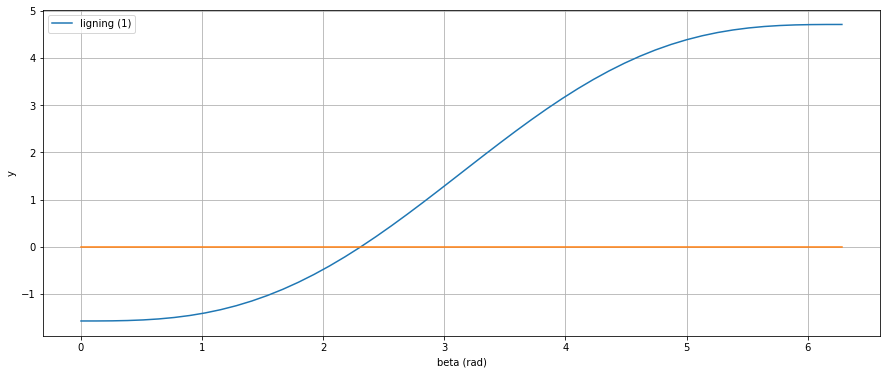

In [59]:
plt.figure(figsize=(15,6)) #setter størrelse på plottet
radians = np.linspace(0,2*np.pi) # array over radianer
plt.plot(radians,f(radians),label ="ligning (1)") # plotter f(x) funksjonen
plt.plot(radians, 0*radians) # y = 0
plt.ylabel("y") #tittel på y-akse
plt.xlabel("beta (rad)") #tittel på x-akse
plt.legend()  #plasserer legend 
plt.grid() #rutenett
plt.show() #aktiverer plottet 

Fra plottet ser vi at roten vår ligger i intervallet [2, 3]. Derfor velger vi dette som vårt startintervall.

In [60]:
#Forklaring av parametre:
# f: funksjonen vi skal finne nullpunktet til
# a: intervallet begynner her
# b: intervallet slutter her
# tolBisection: toleransen på roten vår
# maxIter: antall iterasjoner
def bisection(f, a, b, tolBisection, max_iter):
    fa = f(a) 
    fb = f(b)
    
    for k in range(max_iter):
        c = 0.5*(a+b) #finner midtpunktet i intervallet
        fc = f(c)
        if abs(f(c)) < 1.e-14 or (b-a) < 2*tolBisection: #Roten er funnet!
            break 
        elif fa*fc < 0:               
            b = c #Roten er i [a, c]                
        else:
            a = c #Roten er i [c, b]
    return c

In [61]:
rotBisection = bisection(f, 2, 3, 10**(-6), 100) #løsningen av halveringsmetoden
%timeit bisection(f, 2, 3, 10**(-6), 100) #Finner kjøretiden til halveringsmetoden
print(f"Rot gitt av halveringsmetoden gir {round(rotBisection*180/np.pi,5)} grader og {round(rotBisection,5)} radianer") # printer løsningen for både grader og radianer

95.5 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Rot gitt av halveringsmetoden gir 132.3465 grader og 2.30988 radianer


Her ser vi at halveringsmetoden gir oss et svar som virker rimelig fra det første plottet vårt. Vi kan også plotte punktet vi har fått sammen med funksjon ([1](#mjx-eqn-eq1)). 

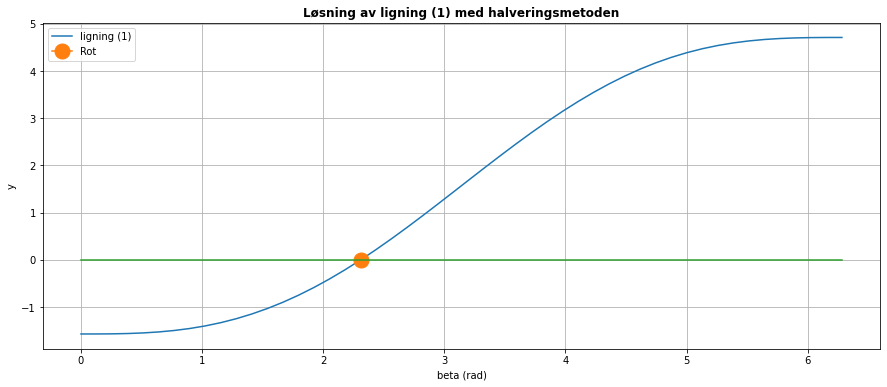

In [62]:
plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(radians,f(radians),label ="ligning (1)") # ploter funksjoenen for å finne nullpunktet visuelt
plt.plot(rotBisection,f(rotBisection),marker = "o", markersize = 15, label = "Rot") #plotter punktet
plt.plot(radians, 0*radians) # y = 0
plt.xlabel("beta (rad)") #tittel på x-akse
plt.ylabel("y") #tittel på y-akse
plt.title("Løsning av ligning (1) med halveringsmetoden", fontweight= "bold") #tittel på plottet
plt.legend() #plasserer legend 
plt.grid() #rutenett
plt.show() #aktiverer plottet

Fra plottet så kan vi bekrefte at verdien vi har funnet for beta er i nærheten av det riktige svaret. La oss nå sjekke hvordan beta og kjøretiden endrer seg med fikspunktmetoden. For å få et godt utgangspunkt i fikspunktmetoden, kan det være lurt å velge $radian0$ (gjettet vårt) ved nullpunktet. Derfor har vi valgt å bruke $radian0 = 2$. I tillegg må vi skrive om funksjon ([1](#mjx-eqn-eq1)) slik at roten er et fikspunkt i funksjonen. Da kom vi fram til to funksjoner:
$g(x): \beta = \sin{\beta} + \frac{\pi}{2}$

$h(x): \beta = \arcsin(\frac{\pi}{2}-\beta)$

Her må vi velge den funksjonen som konvergerer mot roten vår. For å sjekke om funksjonen konvergerer må vi finne absoluttverdien av den deriverte i $x = radian0$. Hvis denne verdien er mindre enn 1, så vil denne funksjonen konvergere mot roten. Hvis ikke så divergerer den.

$$g’(x)  = \cos(x)$$

$$h’(x) = \frac{-2}{\sqrt{-\pi^2-4x^2+4\pi x+4}}$$

$$|G’(radian0)| = 0.42$$

$$|H’(radian0)| = 1.11$$

Her ser vi at vi må bruke g(x), siden denne konvergerer mot roten. Vi kaller denne funksjonen for fixedPointFunction.

In [63]:
#Forklaring av parametre:
# fixedpointFunction: funksjonen vi skal finne nullpunktet til
# radian0: gjettet vårt
# tol: toleransen 
# maxIter: antall iterasjoner
def fixedpoint(fixedpointFunction, radian0, tol, maxIter):
    x = radian0
    for k in range(maxIter):        
        xOld = x # holder på gammelverdi
        x = fixedpointFunction(x) #ny iterasjon 
        err = abs(x-xOld) #feilestimatet
        if err < tol: #Roten er funnet!
            break
    return x

#funksjon som brukes for å finne roten vha. fikspunktmetoden (g(x))
def fixedpointFunction(x):
    return np.sin(x)+np.pi/2

In [64]:
radian0 = 2 # gjettet vårt
tol = 1.e-6 # maxstørrelsesordnen på feilen vi tilatter
maxIter = 35 # antall iterasjoner som gjøres
rotFixedpoint = fixedpoint(fixedpointFunction, radian0, tol, maxIter) #løsningen med fikspunktmetoden
%timeit fixedpoint(fixedpointFunction, radian0, tol, maxIter) #Finner kjøretiden til fikspunktmetoden
print(f"Rot gitt av fixedpoint metoden på funksjon g gir {round(rotFixedpoint*180/np.pi,5)} grader og {round(rotFixedpoint,5)} radianer") # printer løsningen for både grader og radianer

68 µs ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Rot gitt av fixedpoint metoden på funksjon g gir 132.34644 grader og 2.30988 radianer


Vi får da en rot som ser ut til å være riktig basert på plottet. Kjøretiden til fikspunktmetoden er noe raskere enn halveringsmetoden. Ved en kjøring har dette svært lite å si, men senere i rapporten er vi nødt til å gjøre mange utregninger og da vil denne tiden ha en større betydning. Når det er sagt finnes det situasjoner hvor man ikke har tilgang til den analytiske løsningen. Da er det ikke like lett å finne et gjett som gir konvergens. Derimot vil det være mulig å finne en rot med halveringsmetoden om vi bare gir et stort nok intervall og venter lenge nok.

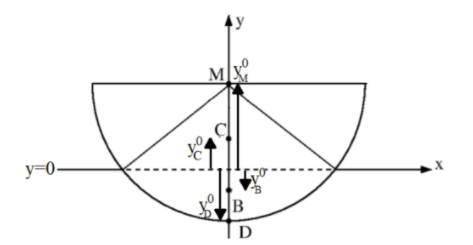

Figurbeskrivelse: Alle størrelser som er gitt i figuren er skalare størrelser. Altså, pilene representerer ikke vektorer.

Vi lar skipet være i likevekt og vannflaten være definert i y = 0. Vi beregner deretter høyden over vannet til metasenteret ($y_{M}$), skipets massesenter ($y_{C}$), skipets dypeste punkt ($y_{D}$) og angrepspunktet til oppdriftskraften ($y_{B}$). Her har vi brukt ligningene under for å beregne størrelsene. 

$y^{0}_{M} = Rcos{\beta}/2$


$y^{0}_{C} = y^{0}_{M} - h = Rcos{\beta}/2 - 4R/3\pi$


$y^{0}_{B} = y^{0}_{M} - Y^{0}_{MB} = Rcos\beta/2 - 4R\sin^3(\beta/2)/3(\beta-\sin\beta)$


$y^{0}_{D} = y^{0}_{M} - R = Rcos\beta/2 - R$


In [65]:
beta = rotFixedpoint #vinkelen ved likevekt (fikspunktmetoden)
#Vannoverfalten ligger i y=0
yM = R*np.cos(beta/2) #y-koordinatet til metasenteret 
yC = abs(yM - h) #y-koordinatet til massesenteret 
yB = yM - 4*R*(np.sin(beta/2))**3 / (3*(beta- np.sin(beta))) #y-koordinatet til angrepspunktet til oppdriftskraften 
yD = yM - R #y-koordinatet til skipets dypeste punkt 
omega0 = np.sqrt(m*g*h/Ic)

Når skipet går ut av likevekt, vil vi få et vinkelutslag lik $\theta$ mellom skipets midtpunkt og loddlinja fra M. Denne vinkelen er sentral for å kunne bestemme bevegelsen til skipet. Ved å bruke et uttrykk for rotasjonsbevegelsen, kan vi utlede et sett med differensialligninger som kan hjelpe oss i senere utregninger.

Vi introduserer $\vec{w}(t) = \begin{vmatrix}
\theta(t) & \omega(t)
\end{vmatrix}^T$, der $\omega = \frac{d\theta}{dt}$. 

Vi har at $\sum{\tau} = I_c\frac{d\omega}{dt}$, hvor $\sum{\tau}$ i vårt tilfelle er det samme som $\tau_B$, som igjen er lik $-F_Bh\sin(\theta)$. 

Altså har vi at:
$$\sum{\tau} = I_c\frac{d\omega}{dt}$$


$$-F_Bh\sin(\theta) = I_c\frac{d\omega}{dt}$$


$$-F_Bh\sin(\theta) = I_c\ddot{\theta}$$

Vi skal senere bruke Euler, så det vil være nødvendig å ha en differensialligning av første orden. Nå har vi kun en differensialligning av andre orden. Den ønsker vi å skrive om til to første orden. Dette kan gjøres ved å introdusere en vektorfunksjon $\vec{f}$.



Vi kan bruke at $\dot{\theta} = \omega(t)$ og får dette settet med ligninger:

$$\dot\theta = \omega(t)$$

$$\ddot\theta = \frac{-F_Bh \sin{\theta}}{I_c} $$

Dermed har vi at: 


\begin{alignat*}{2}
    \quad &
    \begin{vmatrix}
      \dot\theta\\
      \ddot\theta
      \end{vmatrix} \qquad&
    =\quad &
    \begin{vmatrix}
      \omega(t) \\
      -\frac{F_Bh}{I_C}\sin\theta
    \end{vmatrix}
\label{eq2}\tag{2}
  \end{alignat*}


Dermed har vi at:

$$\frac{d\vec{w}}{dt} = \vec{f}(t,\vec{w})$$


Hvor 

$$\vec{f}(t,\vec{w}) = 
\begin{vmatrix}
      \omega(t) \\
      -\frac{F_Bh}{I_C}\sin\theta
    \end{vmatrix}$$   

Nå skal vi løse et initialverdiproblem knyttet til ligning ([2](#mjx-eqn-eq2)), der initialbetingelsene er
$\theta(t=0) = 20^\circ$ og $\omega(t=0) = 0$

Det finnes mange numeriske metoder på å løse slike ordinære differensialligninger. I dette tilfellet har vi valgt å bruke Eulers metode.

In [8]:
#Forklaring av parametre:
# f = diffligningen vi skal løse 
# t = tiden
# w = vektor på formen [theta, omega]
# stepSize = lengden mellom tn og tn+1
def euler(f, t, w, stepSize):
    #Ett steg av eulers metode
    wNext = w + stepSize*f(t,w)
    tNext = t + stepSize
    
    return wNext, tNext

In [10]:
#Forklaring av parametre:
# f = diffligningen vi skal løse 
# t0 = starttid 
# tEnd = sluttid 
# w0 = initialbetingelser 
# stepSize = lengde mellom tn og tn+1
def odeSolver(f, t0, tEnd, w0, stepSize, method):
    N = int(np.ceil((tEnd-t0)/stepSize)) #antall iterasjoner gjennom euler
    t = np.zeros(N) #en array over tidssteg
    t[0] = t0 #initialbetingelse
    wArray = np.zeros((N,len(w0))) #en array som holder på verdier fra Eulers metode
    wArray[0] = w0 #initialbetingelse
    
    #Starter eulers metode fra initialbetingelsene 
    tOld = t0
    wOld = w0
    
    n = 0
    while n<(N-1):
        wNext, tNext = method(f, tOld, wOld, stepSize)
        #Setter resultatet fra euler inn i arrayene våre
        t[n] = tNext
        wArray[n] = wNext

          #Setter gammel lik ny slik at vi neste gang kan kjøre euler for de nye verdiene
        tOld = tNext
        wOld = wNext

        n+=1

    stepSize = tEnd - tOld #finner steglengden som trengs for å lande akkurat på t=20
    wNext, tNext = method(f, tOld, wOld, stepSize) #kjører ett steg av euler med denne steglengden
    t[n] = tNext
    wArray[n] = wNext
        
    return t, wArray

In [5]:
#funksjonen vi utledet, se ligning (1)
def diffEq1(t,w):
    fArray = np.zeros(2) #lager en tom 1x2-array
    fArray[0] = w[1] #theta = d(omega)/dt 
    fArray[1] = -Fb*h/Ic*np.sin(w[0]) #omega = d(theta)/dt 
    
    return fArray

Fra koden ser vi at det er enkelt å implementere Eulers metode. Men en ulempe med denne metoden er at unøyaktigheten er proporsjonal med økende steglengde. Samtidig kan vi ikke velge en altfor liten steglengde, siden dette vil øke tiden det tar å kjøre koden. Altså må vi finne en steglengde som gir oss gode nok resultater og rask kjøretid. Derfor har vi valgt å plotte for ulike steglengder. Vi regner også ut avviket mellom steglengde = $0.0001$ og en valgt steglengde. Dette gjør vi ved å se på avviket i ett punkt, hvor dette punktet befinner seg i t = 20. Vi sammenligner også plottene til de ulike steglengdene med steglengde = $0.0001$. Grunnen til dette er fordi det er den laveste steglengden vi har plottet for, og dermed er mest nøyaktig. 

In [6]:
w0 = [np.radians(20), 0] #initialbetingelser på formen: w0 = [theta(0), omega(0)]

#tiden går fra 0s til 20s
t0 = 0
tEnd = 20

[[ 3.49065850e-01 -4.45175607e-05]
 [ 3.49065846e-01 -8.90351214e-05]
 [ 3.49065837e-01 -1.33552682e-04]
 ...
 [-2.78011241e-01  2.39664527e-01]
 [-2.77987275e-01  2.39700249e-01]
 [-2.77963305e-01  2.39735968e-01]]
[[ 3.49065850e-01 -4.45175607e-02]
 [ 3.44614094e-01 -8.90351214e-02]
 [ 3.35710582e-01 -1.33007744e-01]
 [ 3.22409808e-01 -1.75887887e-01]
 [ 3.04821019e-01 -2.17129692e-01]
 [ 2.83108050e-01 -2.56193822e-01]
 [ 2.57488668e-01 -2.92553067e-01]
 [ 2.28233361e-01 -3.25698840e-01]
 [ 1.95663477e-01 -3.55148603e-01]
 [ 1.60148617e-01 -3.80454096e-01]
 [ 1.22103207e-01 -4.01210152e-01]
 [ 8.19821918e-02 -4.17063721e-01]
 [ 4.02758197e-02 -4.27722626e-01]
 [-2.49644288e-03 -4.32963536e-01]
 [-4.57927964e-02 -4.32638597e-01]
 [-8.90566562e-02 -4.26680261e-01]
 [-1.31724682e-01 -4.15103906e-01]
 [-1.73235073e-01 -3.98008076e-01]
 [-2.13035880e-01 -3.75572300e-01]
 [-2.50593110e-01 -3.48052681e-01]
 [-2.85398379e-01 -3.15775629e-01]
 [-3.16975941e-01 -2.79130237e-01]
 [-3.44888965e

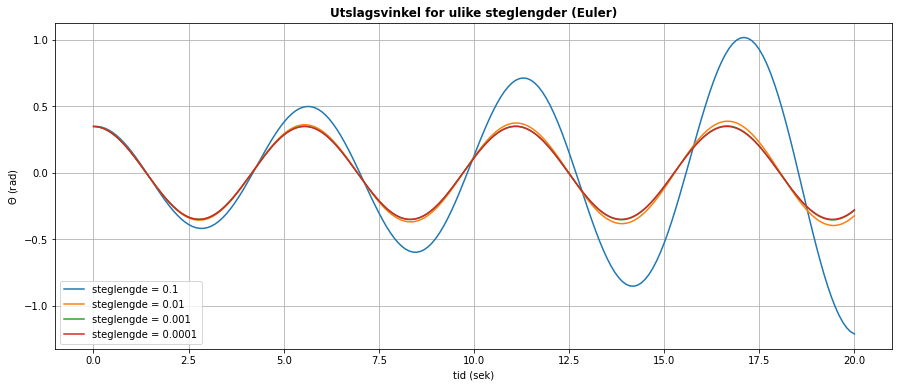

In [11]:
#Sjekker hvilken steglengder vi burde bruke
runTime = [] #array som skal holde kjøretiden til alle steglengdene
stepSizeCompare = 0.0001 #steglengden vi skal sammenligne med
stepSizeArray = [0.1, 0.01, 0.001, 0.0001] #array over ulike steglengder
plt.figure(figsize=(15,6)) #setter størrelse på plottet
tCompate, wCompare = odeSolver(diffEq1, t0, tEnd, w0, stepSizeCompare, euler) #løser ODE med euler og gitt steglengde 
for stepSize in stepSizeArray: #plotter for ulike steglengder
    startTime = time.time() #starter tiden
    tNumDiffEq1, wNumDiffEq1 = odeSolver(diffEq1, t0, tEnd, w0, stepSize, euler) #løser ODE med euler og gitt steglengde
    endTime = time.time() #avslutter tiden
    deltaTime = endTime-startTime #regner ut kjøretiden
    runTime.append(deltaTime) #setter inn i runTime-arrayen 
    plt.plot(tNumDiffEq1, wNumDiffEq1[:, 0],label = f"steglengde = {stepSize}") #plotter theta som en funksjon av t
    if stepSize != stepSizeCompare: #vil ikke sammenligne feilen i steglengden med seg selv
        print(f"Maksimal feil mellom steglengene = {stepSize} og {stepSizeCompare} er {abs(wCompare[tEnd,0] - wNumDiffEq1[tEnd,0])}") #Printer ut avviket
    
#Her plotter vi theta vha. Euler for ulike steglengder
plt.legend(loc = "lower left") #plasserer legend 
plt.title("Utslagsvinkel for ulike steglengder (Euler)", fontweight= "bold") #tittel på plottet
plt.ylabel("$\Theta$ (rad)") #navn på y-aksen
plt.xlabel("tid (sek)") #navn på x-aksen
plt.grid() # rutenett
plt.show() # aktiverer plottet

Fra plottet ser vi at forskjellen mellom steglengde = $0.1$ og $0.0001$ er betydelig stor. Videre er forskjellen mellom steglengde = $0.01$ og $0.0001$ veldig liten. Til slutt ser vi at steglengde = $0.001$ og $0.0001$ gir samme plott. Dette kan bekreftes ved å se på differansene våre. Avviket minker omtrent med størrelsesorden $10^{-3}$ når vi minker steglengden med $10^{-1}$.

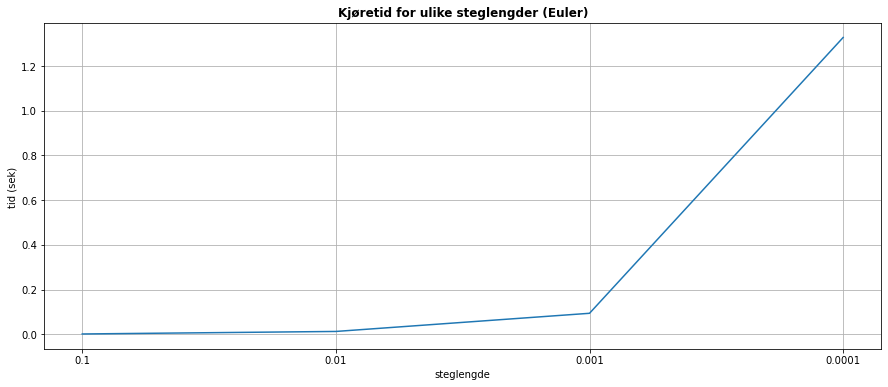

In [71]:
#Her plotter vi kjøretiden for ulike steglengder
stepsizeLength= range(len(stepSizeArray))
plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(stepsizeLength,runTime) #plotter kjøretiden mot steglengde
plt.xticks(stepsizeLength,stepSizeArray) #deler opp x-aksen i steglengdene vi har valgt
plt.title("Kjøretid for ulike steglengder (Euler)", fontweight= "bold") #tittel på plottet
plt.ylabel("tid (sek) ") #navn på y-aksen
plt.xlabel("steglengde") #navn på x-aksen
plt.grid() #rutenett
plt.show() #aktiverer plottet

I tillegg ser vi at kjøretiden øker relativt fra steglengde = $0.001$ og $0.0001$, men holder seg omtrent konstant utenom det. Derfor har vi valgt å bruke steglengde lik $0.001$ fordi dette gir hos gode nok resultater med rask nok kjøretid. Vi kommer til å bruke steglengde lik $0.001$ videre i rapporten.

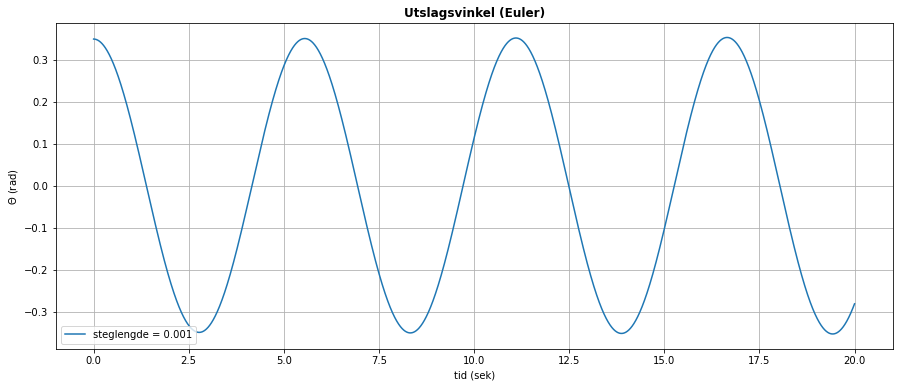

In [72]:
stepSize = 0.001
tNumDiffEq1, wNumDiffEq1 = odeSolver(diffEq1, t0, tEnd, w0, stepSize, euler) #løser ODE med euler og gitt steglengde
plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(tNumDiffEq1, wNumDiffEq1[:, 0], label = f"steglengde = {stepSize}") #plotter theta-funksjonen mot tiden
plt.legend(loc = "lower left") #plasserer legend
plt.title("Utslagsvinkel (Euler)", fontweight= "bold") #tittel på plottet
plt.ylabel("$\Theta$ (rad)") #navn på y-aksen
plt.xlabel("tid (sek)") #navn på x-aksen
plt.grid() # rutenett 
plt.show() # aktiverer plottet 

I fysikk er det veldig vanlig å bruke tilnærminger når man skal løse f.eks. ligninger. En tilnærming som er mye brukt er småvinkelapproksimasjon. Vi har lyst til å utforske hvor god denne approksimasjonen egentlig er. Fremgangsmåten vi har brukt er å løse ligning ([2](#mjx-eqn-eq2))  med og uten småvinkelapproksimasjon. Da ender vi opp med to diffligninger som skal bli løst med Euler som vi allerede har implementert, der ligning ([2](#mjx-eqn-eq2))​​ er uten småvinkelapproksimasjon. Med småvinkelapproksimasjon vil den se slik ut:

\begin{alignat*}{2}
    \quad &
    \begin{vmatrix}
      \dot\theta\\
      \ddot\theta
      \end{vmatrix} \qquad&
    =\quad &
    \begin{vmatrix}
      \omega(t) \\
      -\frac{F_Bh}{I_C}\theta
    \end{vmatrix}
\label{eq3}\tag{3}
  \end{alignat*}


Dette gjør vi for to forskjellige initialverdiproblemer. Først med $\theta(t=0) = 20^\circ$, og deretter $\theta(t=0) = 1^\circ$ ($\omega(t=0) = 0$ i begge tilfellene).  

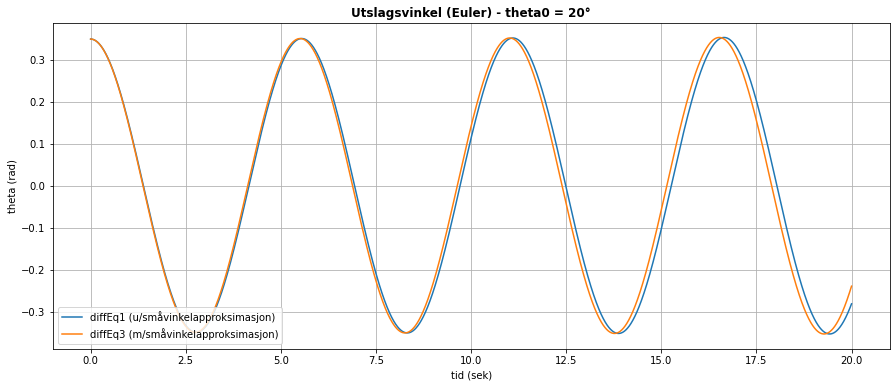

In [73]:
def diffEq3(t,w):
    fArray = np.zeros(2)
    fArray[0] = w[1]
    fArray[1] = -m*g*h/Ic*w[0]
    return fArray

#Her bruker vi theta0 = 20 grader
w0 = [np.radians(20), 0] #initialbetingelser på formen: w0 = [theta(0), omega(0)]
stepSize = 0.001
tAnalytical = np.linspace(0,tEnd,int(tEnd/stepSize+1))

tNumDiffEq1, wNumDiffEq1 = odeSolver(diffEq1, t0, tEnd, w0, stepSize, euler)
tNumDiffEq3, wNumDiffEq3 = odeSolver(diffEq3, t0, tEnd, w0, stepSize, euler)

plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(tNumDiffEq1, wNumDiffEq1[:, 0],label = "diffEq1 (u/småvinkelapproksimasjon)")
plt.plot(tNumDiffEq3, wNumDiffEq3[:, 0],label = "diffEq3 (m/småvinkelapproksimasjon)")


plt.legend(loc = "lower left")
plt.title("Utslagsvinkel (Euler) - theta0 = 20°", fontweight= "bold")
plt.ylabel("theta (rad)")
plt.xlabel("tid (sek)")
plt.grid()
plt.show()

Her ser vi at ligning([3](#mjx-eqn-eq3)) allerede avviker ved 20 grader, noe som tyder på at småvinkelapproksimasjonen ikke stemmer så godt. Vi ser at løsningen med approksimasjonen er forskjøvet mot venstre. Dette skjer fordi x (med approksimasjon) og sin(x) (uten approksimasjon) har ulik stigningstall ved 20 grader - noe vi kan se i plottet under (vinkelapproksimasjon). Og siden Euler bruker stigningstallet for å finne neste steg, så x vil konvergere raskere mot amplituden enn sin(x). Dermed vil funksjonen med småvinkelapproksimasjon ligge “foran”, altså være forskjøvet mot venstre. 

Men for hvilke vinkler kan man bruke approksimasjonen? En måte vi kan finne ut av dette på er å plotte $\sin(x)$ og $x$ sammen. I tillegg har vi plottet feilen mellom $\sin(x)$ og $x$. 

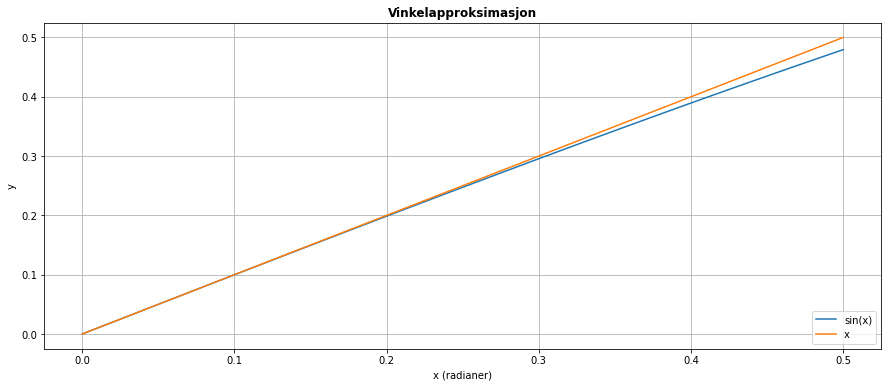

In [74]:
def sinusFunction(x):
    return np.sin(x)

plt.figure(figsize=(15,6)) #setter størrelse på plottet
radians = np.linspace(0, 0.5, 100) #lager en x-aksen som går fra 0 til 0.5 radianer med 100 punkter i mellom
plt.plot(radians, np.sin(radians), label = "sin(x)") #plotter sin(x) - funksjonen
plt.plot(radians, radians, label = "x") #plotter x - funksjonen
plt.title("Vinkelapproksimasjon", fontweight= "bold")
plt.ylabel("y") #navn på y-aksen
plt.xlabel("x (radianer)") #navn på x-aksen
plt.legend(loc = "lower right") #plasserer legend 
plt.grid() #rutenett
plt.show() #aktiverer plottet

Der vi plotter $\sin(x)$ og $x$ ser vi at fra 0.3 radianer så “skiller” funksjonene, altså vil vi få et betydelig stort avvik etter dette punktet. Dette kan bekreftes fra feilestimat-plottet vårt. 

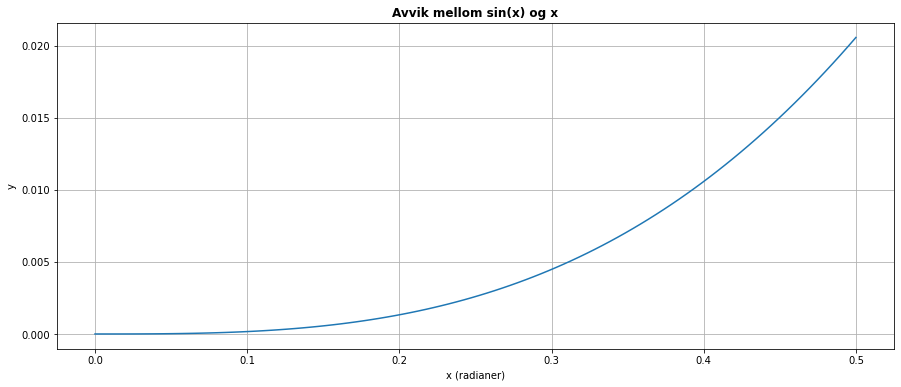

In [75]:
plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(radians, abs(radians - np.sin(radians)))
plt.title("Avvik mellom sin(x) og x", fontweight= "bold")
plt.ylabel("y") #navn på y-aksen
plt.xlabel("x (radianer)") #navn på x-aksen
plt.grid() #rutenett
plt.show() #aktiverer plottet

Feilen vokser eksponentielt, og etter 0.3 så vil feilen være større enn 0.005. Om denne feilen er stor eller lav spørs hvor stor avviket vi godkjenner. Hvis man kun vil være på den sikre siden, så burde man bruke approksimasjonen for vinkeler mindre enn 0.2. Da vil feilen alltid være mindre enn 0.0025. Derfor stemmer approksimasjonen godt for $\theta_0 = 1$, som vi kan se i plottet under.

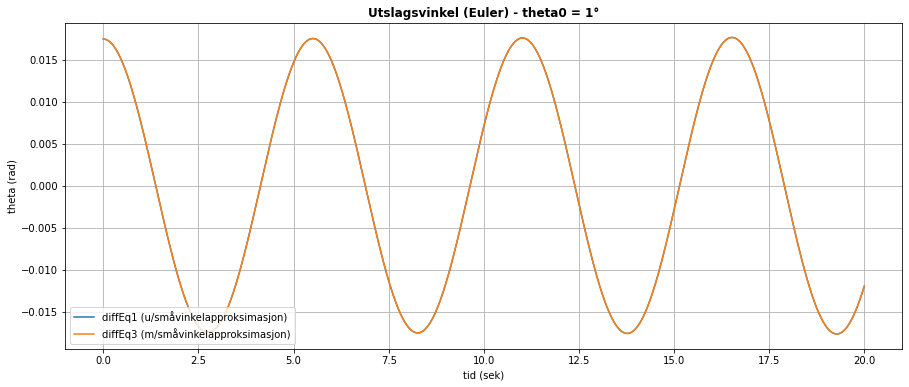

In [76]:
#Her bruker vi theta0 = 1 grad
w0 = [np.radians(1), 0]
stepSize = 0.001
tAnalytical = np.linspace(0,tEnd,int(tEnd/stepSize+1))

tNumDiffEq1, wNumDiffEq1 = odeSolver(diffEq1, t0, tEnd, w0, stepSize, euler) 
tNumDiffEq3, wNumDiffEq3 = odeSolver(diffEq3, t0, tEnd, w0, stepSize, euler)

plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(tNumDiffEq1, wNumDiffEq1[:, 0],label = "diffEq1 (u/småvinkelapproksimasjon)") #plotter theta som en funksjon av t (u/approks.)
plt.plot(tNumDiffEq3, wNumDiffEq3[:, 0],label = "diffEq3 (m/småvinkelapproksimasjon)") #plotter theta som en funksjon av t (m/approks.)

plt.legend(loc = "lower left")
plt.title("Utslagsvinkel (Euler) - theta0 = 1°", fontweight= "bold") #tittel
plt.ylabel("theta (rad)") #navn på y-aksen
plt.xlabel("tid (sek)") #navn på x-aksen
plt.grid() #rutenett
plt.show() #aktiverer plottet

Vi har sett hvor viktig det er å velge en liten steglengde slik at avviket blir minst mulig. Men som sagt vil små steglengder øke kjøretiden til programmet. Når flere diffligninger er introdusert, vil kjøretiden nok engang øke. Det er samtidig ønskelig å få mer nøyaktighet for alle steglengder. Dette gjør vi ved å implementere Runge-Kutta 4. Senere vil vi sammenligne RK4 og Euler. Da vil vi se hvorfor RK4 er en bedre metode å benytte seg av.  
Vi har valgt steglengde = $0.001$ da steglengden gir gode resultater for Euler. Derfor vil den også gi gode resultater for RK4. Dette kommer av at RK4 er av høyere orden enn Euler.

In [77]:
#Forklaring av parametre:
# f = diffligningen vi skal løse 
# t = tiden
# w = vektor på formen [theta, omega]
# stepSize = lengden mellom tn og tn+1
def rk4(f, t, w, stepSize): 
    # Et steg av rung-kutta 4 
    k1 = f(t, w)
    k2 = f(t + stepSize/2, w + (stepSize/2)*k1)
    k3 = f(t + stepSize/2, w + (stepSize/2)*k2)
    k4 = f(t + stepSize,   w + stepSize * k3)
    wNext = w + (stepSize/6)*(k1 + 2*k2 + 2*k3 + k4) # neste w steg
    tNext = t + stepSize # neste t steg
    return wNext,tNext

For å undersøke feilen i de to metodene vi nå har utledet (Euler og Runge-Kutta 4), kan det være nyttig å utlede den analytiske løsningen av differensialligningen ([3](#mjx-eqn-eq3)). Det er nettopp dette vi kommer til å gjøre nedenfor. 

Oppdriftens dreiemoment om C er $\tau_B = −mgh\sin\theta$, og hvis vi betrakter små utsving omkring likevekt, er $\sin(\theta) \approx \theta$. Newtons 2. lov for rotasjon om C blir dermed:

$$-mgh\theta = I_C\ddot{\theta}$$


$$\ddot{\theta} + \frac{mgh}{I_c}\theta = 0 \label{eq4}\tag{4}$$

$$\ddot{\theta} + \omega_0^2\theta = 0 $$

Antar at løsningen til $\theta$ har formen: 
$$\theta(t) = A\cos(\omega t + \phi) + B\sin(\omega t + \phi)$$

Setter inn for ligningen lik null og får at:

$$-\omega^2[A\cos(\omega t) + B\sin(\omega t)] + \omega_0^2[A\cos(\omega t) + B\sin(\omega t)] = 0$$

Fra dette uttrykket, får vi at:

$$\omega = \omega_0 = \sqrt{\frac{mgh}{I_c}}$$

Setter videre inn initialbetingelsene: 

$$\theta(0) = 0.01$$

$$\omega(0) = 0$$

I løsningen vår:

$$\theta(0) = A\cos(0)+Bsin(0) = 0.01$$

Dette gir oss at $A = 0.01$.

$$\theta'(0) = \omega(0) = \omega B\cos(\omega 0 ) - \omega A\sin(\omega 0 ) = \omega B = 0$$

Dette gir oss at $B = 0$.

Dermed får vi at:

$$\tilde{\theta}(t) = 0,01\cos(\omega t + \phi)$$

Der $\omega = \sqrt{\frac{mgh}{I_c}}$


Så langt har vi benyttet RK4 og Euler for å løse differensialer. For å avgjøre hvilken metode som er hensiktsmessig å bruke, så kan vi finne hvilken metode som gir oss mest riktige resultater. I tillegg kan det være interessant å se på nøyaktig hvor nærme Euler og RK4 er det analytiske svaret. 

For å gjøre dette er det lettere å lese av størrelsesorden til differansen benyttet vi logaritmisk skala på aksene våres.

In [78]:
def line(x, a, b):
    return a * x + b

def analyticalDiff3(t):
    return 0.01*np.cos(omega0*t)

#Forklaring av parametre:
# f = diffligningen vi skal løse 
# t = tiden
# tEnd = sluttiden
# w = vektor på formen [theta, omega]
def differencePlot(f,t0,tEnd,w0):
    i = 0.1 # Slutt steglengden
    n = int(i/0.001) # Antall iterasjoner 
    
    thetaEulerArray = np.zeros(n) # array over theta fra euler
    thetaRk4Array = np.zeros(n) # array over theta fra Rk4
    stepSizeList = np.zeros(n) # array over steg lengdene vi plotter for
    indexDiff = 0 # indeks i arrayen
    
    while i > 0.0009:
        tNumEq10Euler, wNumEq10Euler = odeSolver(f, t0, tEnd, w0, i, euler) # Utfører euler med steglengde i
        tNumEq10Rk4, wNumEq10Rk4 = odeSolver(f, t0, tEnd, w0, i, rk4) # Utfører RK4 med steglengde i
        tEuler = tNumEq10Euler[-1] # tEuler = tEnd
        tRk4 = tNumEq10Rk4[-1] # tRk4 = tEnd

        thetaEulerArray[indexDiff] = abs(wNumEq10Euler[-1,0]-analyticalDiff3(tEuler)) # differansen - Euler
        thetaRk4Array[indexDiff] = abs(wNumEq10Rk4[-1,0]-analyticalDiff3(tRk4)) # differansen - RK4
        stepSizeList[indexDiff] = i # brukt steglengde 
        
        indexDiff += 1 # øker indekseringen
        i -= 0.001 # minker steglengden for neste kjøring
    
    plt.figure(figsize=(15, 6)) # setter størrelse på plottet
    plt.title("Differanse mellom Euler og RK4 (logaritmisk skala)", fontweight= "bold") # tittel
    plt.plot(stepSizeList,thetaEulerArray,label = "Euler") # plotter differansen for euler med hensyn på steglengden
    plt.plot(stepSizeList,thetaRk4Array, label = "RK4") # plotter differansen for RK4 med hensyn på steglengden
    plt.xlim(min(stepSizeList), max(stepSizeList)) # Gjør at x-aksen går fra stor til liten steglengde
    plt.legend(loc = "lower right") # plasserer legend i nederste høyre hjørne 
    plt.yscale("log") # endrer y-aksen til logaritmisk
    plt.xscale("log") # enderer x-aksen til logaritmisk                                    
    plt.xlabel('steglengde ') # tittel på x-aksen
    plt.ylabel('differanse') # tittel på y-akse
    slopeYConstantEuler, pcov = curve_fit(line, np.log(stepSizeList), np.log(thetaEulerArray)) # finner stigningstallet
    print(f"Konvergensordenen for Euler er {slopeYConstantEuler[0]}") # printer stigningstallet
    slopeYConstantRK4, pcov = curve_fit(line, np.log(stepSizeList[:80]), np.log(thetaRk4Array[:80])) # finner signinstallet 
    print(f"Konvergensordenen for RK4 er {slopeYConstantRK4[0]}") # printer stigningstallet
    plt.grid() # rutenett 
    plt.show() # aktiverer plottet

Konvergensordenen for Euler er 1.2325800534904303
Konvergensordenen for RK4 er 3.9478346639821655


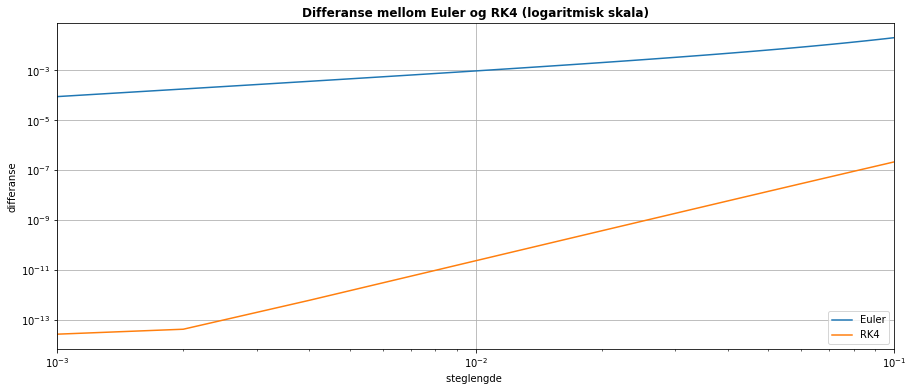

In [79]:
# samme inisialbetingelser som den analytiske løsningen
t0 = 0 # starttid        
tEnd = 20 # sluttid
w0 =  [0.01, 0] # initialbetingelser
differencePlot(diffEq3,t0,tEnd,w0) # Utregningen og plottingen av differenisalet 

For små steglengder ser vi et lite flatt området, dette kommer av at avrundingsfeilene maskinen gjør ligger på ca samme størrelsesorden som differansen ved små steglengder.


Vi ser at forskjellen mellom Euler og den analytiske løsningen er ganske mye større enn forskjellen mellom RK4 og den analytiske løsningen. Vi kan se at differansen på sitt største i Euler har en størrelsesorden som er omtrent 3 ganger så stor som i RK4. Dermed kan vi konkludere med at RK4 er en bedre metode å bruke, enn det Euler er. 

Hvis vi ser litt nøyere på plottet ser det ut til at differansen i RK4 øker raskere enn det differansen i Euler gjør. Og om vi nå regner ut stigningstallet til disse funksjonene ser vi at RK4 får omtrent 4 og Euler får 1.23. Disse tallene er ikke tilfeldige. Tallene representerer konvergensordenen til disse metodene. Om man regner stigningstallet til RK4 over hele intervallet får man ikke et så godt estimatet for konvergensområdet, men her er trikset å kun benytte seg av det området som ikke blir utsatt for “støy”. Konvergensordenen til Euler bør ligge nærmere 1. 


Fra nå av vil vi la mengden fortrengt vann variere. Slik at uttrykket for A blir $\frac{1}{2}R^2(\gamma-\sin{\gamma})$. Dette vil føre til at massesenteret vårt ikke lenger vil være i ro. Siden massesenteret vårt ikke lenger er i ro, vil vi få at summen av kreftene og summen av dreiemoment er et sett med koblede ligninger. Så vi trenger nå at $\vec w$ nå inneholder $x$- og $y$-koordinatene til massesenteret til skipet, samt tilhørende hastigheter $v_x$ og $v_y$. Vi ønsker å gjøre det samme som tidligere, og utlede et uttrykk for en ny vektorfunksjon $\vec f$ lik $\frac{dw}{dt}$.

Vi introduserer en ny $ \vec{w} = \begin{vmatrix}
\theta(t) & \omega(t) & x(t) & y(t) & v_x(t) & v_y(t)
\end{vmatrix}^T$

Vi har fra før at $\sum{\tau} = I_c\frac{d\omega}{dt}\label{eq5}\tag{5}$ hvor $\sum{\tau}$ i vårt tilfelle er det samme som $\tau_B$, som igjen er lik $-F_Bh\sin(\theta)$. 

I tillegg har vi $\sum{\vec{F}} = m\vec{A} = m\frac{d\vec{v}}{dt} = m\frac{d^2\vec{R}}{dt^2}$. Summen av krefter i dette tilfellet er $\sum{\vec{F}} = -mg + A\sigma_0g \label{eq6}\tag{6}$  Siden vi kun har krefter i y-retning, vil vi $\vec{v}$ reduseres til $v_y$

Vi får dermed de koblede differensialligningene:
$$\ddot\theta = \frac{-F_Bh\sin(\theta)}{I_C}$$
$$\frac{dv_y}{dt} = -g + \frac{A\sigma_0g}{m}$$


For $\dot{x}$, $\dot{y}$, $\dot{\theta}$ og $v_x$ har vi: 

$$\dot{x} = v_x$$
$$\dot{y} = v_y$$
$$\dot\theta = \omega$$
$$v_x = 0$$ 

Videre er:

$$ \frac{dw}{dt}= \begin{vmatrix}
\dot\theta \\ \ddot\theta \\ \dot{x} \\ \dot{y} \\ \dot{v_x} \\ \dot{v_y}
\end{vmatrix}$$

Dermed får vi at:

$$ \vec{f} = 
\begin{vmatrix}
\omega \\ -\frac{F_Bh\sin{\theta}}{I_C} \\ 0 \\ v_y \\ 0 \\ -g + \frac{A\sigma_0g}{m}
\end{vmatrix}$$

Altså:

$$
\begin{vmatrix}
\dot\theta \\ \ddot\theta \\ \dot{x} \\ \dot{y} \\ \dot{v_x} \\ \dot{v_y}
\end{vmatrix}
=
\begin{vmatrix}
\omega \\ -\frac{F_Bh\sin{\theta}}{I_C} \\ 0 \\ v_y \\ 0 \\ -g + \frac{A\sigma_0g}{m}
\end{vmatrix}\label{eq7}\tag{7}$$


Fra nå av vil vi bruke Runge Kutta som metode for å løse differensialet. Vi har valgt steglengde = $0.001$, av samme grunn som forklart tidligere. 
Nå som vi har definert en ny $\vec{w}$. Dermed kan vi løse et initialverdiproblem knyttet til differensialet ([7](#mjx-eqn-eq7)).

In [84]:
#funksjonen vi har utledet, se ligning (5)
#Forklaring av parametre:
# t: tidsarray
# w: vektor på formen w =[theta, omega, x-koord til MC, y-koord til MC, V_x til MC, V_y til MC, x-koord til lasten, farten (x-retn.) til lasten]
def diffEq7(t,w):
    fArray = np.zeros(6) #lager f-vektoren så vi skal fylle senere 
    gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) #definerer gamma
    A = 1/2 * R**2 * (gamma - np.sin(gamma)) #definerer A (fortrengt vann)
    Fb = A*sigma0*g #definerer Fb (oppdriften)
    fArray[0] = w[1] #d(theta)/dt
    fArray[1] = (-Fb*h/Ic)*np.sin(w[0]) #d(omega)/dt
    fArray[2] = 0 #d(x-koord. til massesenter)/dt  
    fArray[3] = w[5] #d(y-koord. til massesenter)/dt 
    fArray[4] = 0 #d(v i x-retning)/dt 
    fArray[5] = -g + A*sigma0*g/m #d(v i y-retning)/dt 
    
    return fArray

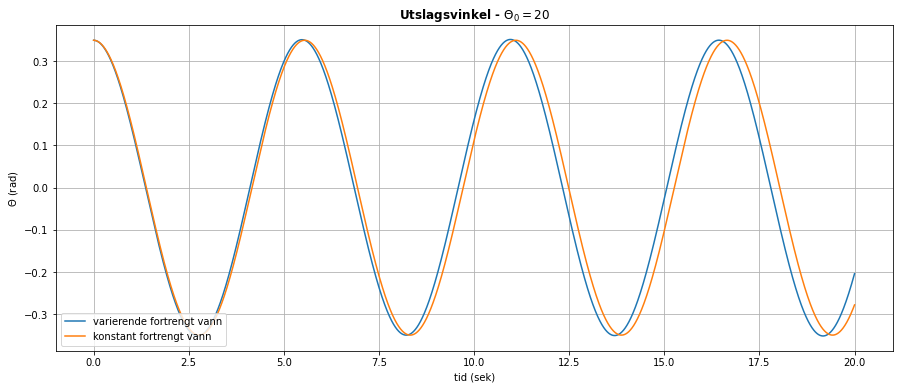

In [85]:
tEnd = 20 #sluttid 
w0 = [np.radians(20), 0] #initialbetingelser på formen: w0 = [theta(0), omega(0)
tNumDiffEq1, wNumDiffEq1 = odeSolver(diffEq1, t0, tEnd, w0, stepSize, rk4)
w0 = [np.radians(20), 0, 0,yC,0, 0] #initialbetingelser
tNumDiffEq7, wNumDiffEq7 = odeSolver(diffEq7, t0, tEnd, w0, stepSize, rk4) #løser ODE med RK4 og gitt steglengde

plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(tNumDiffEq7, wNumDiffEq7[:, 0], label = "varierende fortrengt vann") #plotter theta som en funksjon av tiden
plt.plot(tNumDiffEq1, wNumDiffEq1[:, 0],label = "konstant fortrengt vann") #plotter theta som en funksjon av tiden
plt.xlabel('tid (sek)') # tittel på x-aksen
plt.ylabel("$\Theta$ (rad)") # tittel på y-akse
plt.title("Utslagsvinkel - $\Theta_0 = 20$", fontweight= "bold") #tittel på plottet
plt.legend(loc = "lower left")
plt.grid() #rutenett
plt.show() #aktiverer plott

Her har vi plottet theta som en funksjon av tiden for både konstant og varierende fortrengt vann. Fra plottet ser vi at varierende fortrengt vann er forskjøvet mot venstre relativt til konstant fortrengt vann. Dette kan forklares ved at oppdriften avhenger av fortrengt vann - noe som avhenger av gamma. Her må vi undersøke forholdet mellom gamma og beta - noe vi ser kvantitativt på senere.

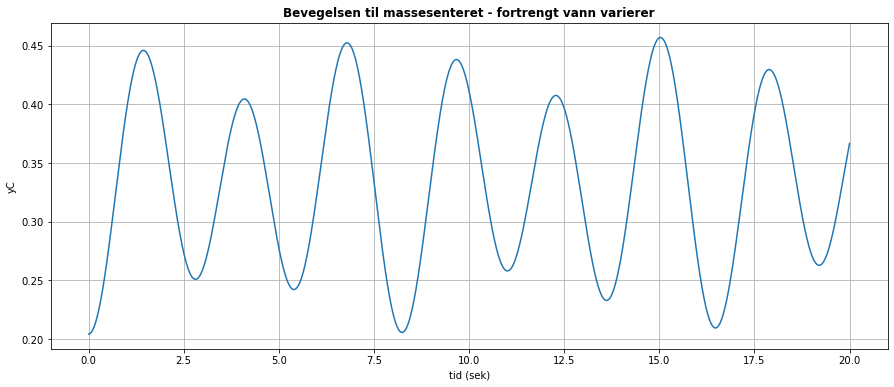

In [86]:
plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(tNumDiffEq7, wNumDiffEq7[:, 3]) #plotter yC som en funksjon av tiden
plt.xlabel('tid (sek)') # tittel på x-aksen
plt.ylabel('yC') # tittel på y-akse
plt.title("Bevegelsen til massesenteret - fortrengt vann varierer", fontweight= "bold") #tittel på plottet
plt.grid() #rutenett
plt.show() #aktiverer plott

Her har vi plottet $y_C$, altså y-koordinatet til massesenteret, som funksjon av t. For å kunne se effekten av varierende fortrengt vann, så har vi valgt å plotte $y_C$ når fortrengt vann er konstant. 

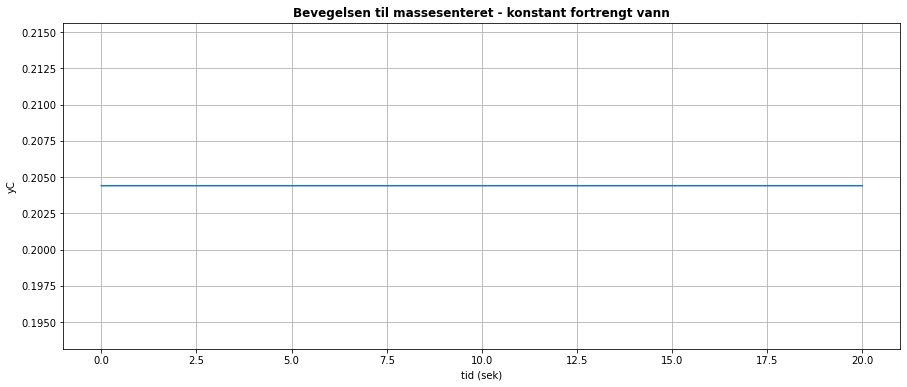

In [89]:
#Lager en array med kun yC-verdier slik at vi kan plotte dette mot tiden
yCArray = np.zeros(len(tNumDiffEq7))
yCArray.fill(yC)

plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(tNumDiffEq7, yCArray) #plotter yC som en funksjon av tide
plt.xlabel('tid (sek)') # tittel på x-aksen
plt.ylabel('yC') # tittel på y-akse
plt.title("Bevegelsen til massesenteret - konstant fortrengt vann", fontweight= "bold") #tittel på plottet
plt.grid() #rutenett
plt.show() #aktiverer plott

Dette plottet blir en rett strek, fordi massesenteret holdes konstant når fortrengt vann ikke varierer. For å få en bedre oversikt over forskjellene mellom disse to plottene har vi valgt å sette det opp i en tabell. Her har vi beregnet gjennomsnitt, maksimums- og minimumsverdi til begge plottene. 

In [92]:
yCAverage = np.average(wNumDiffEq7[:, 3])
yCMax = np.max(wNumDiffEq7[:, 3])
yCMin = np.min(wNumDiffEq7[:, 3])
#Lager en tabelloversikt der vi sammenligner yC konstant og yC varierer 
myTable = PrettyTable(["yC", "Maksimumsverdi", "Minimumsverdi", "Gjennomsnitt"]) #Kolonnetittel
myTable.add_row(["Konstant", yC, yC, yC]) #legger til en rad
myTable.add_row(["", "", "", ""]) #legger til en rad
myTable.add_row(["Varierer",yCMax, yCMin, yCAverage] ) #legger til en rad
print("Sammenligne yC konstant og yC varierer")
print(myTable) #skriver ut tabellen

Sammenligne yC konstant og yC varierer
+----------+---------------------+---------------------+---------------------+
|    yC    |    Maksimumsverdi   |    Minimumsverdi    |     Gjennomsnitt    |
+----------+---------------------+---------------------+---------------------+
| Konstant | 0.20440253477419823 | 0.20440253477419823 | 0.20440253477419823 |
|          |                     |                     |                     |
| Varierer |  0.4571290378876611 | 0.20440282898312775 | 0.33239810955702115 |
+----------+---------------------+---------------------+---------------------+



Vi ser at verdiene for konstant fortrengt vann er konstant. Vi kaller denne verdien for $y_{C0}$. Videre ser vi fra tabellen at alle verdiene for massesenteret for varierende fortrengt vann er høyere enn $y_{C0}$. For å forstå hvorfor effekten av varierende fortrengt vann gir oss i høyere massesenter, så må vi se på ligningene gitt for fortrengt vann i begge tilfellene (varierende og konstant):


$A = \frac{1}{2}R^2(\gamma-\sin{\gamma})$


$A_0 = \frac{1}{2}R^2(\beta - \sin{\beta})$


Her ser vi at forskjellen mellom i disse ligningene er størrelsene $\beta$ og $\gamma$. Disse størrelsene er definert med gitte formler, noe vi har brukt tidligere. Det kan være litt vanskelige å bruke formelen for $\gamma$, siden denne varierer med andre størrelser knyttet til skipets dynamikk. Dermed har vi valgt å ta i bruk figurer slik at det er lettere å få en fysisk forståelse rundt $\beta$ og $\gamma$. 


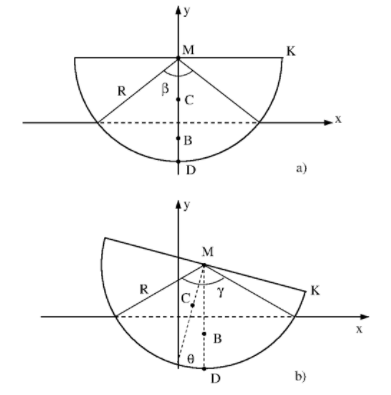

Fra figuren kan vi se at mesteparten av tiden så vil $\gamma$ være større enn $\beta$. De tilfellene der dette ikke stemmer er når skipet letter opp med theta lik $0$. Da vil  $\gamma$ være omtrent lik $\beta$. Dette forklarer at vi får en minimumsverdi for $y_C$ (varierende fortrengt vann) som er omtrent lik $\beta$. Dette forklarer også utslagsvinkel-plottet vårt, fordi oppdriften generelt vil være større. Da vil også vinkelhastigheten være høyere som gir redusert periode, sammenlignet med konstant fortrengt vann.

Nå som både vugging og rotasjon er inkludert i funksjonene våre, så vil det være interessant å se på når skipet kantrer. Ved kantring vil alle komponentene settes til 0, med unntak av $\theta$ hvor vi setter den til å være $90^\circ$  siden dette vil fint illustrere at skipet har kantra. Vi har løst oppgaven ved å bruke et kriterium for kantring: $\theta > \frac{\pi-\gamma}{2}$. I tillegg har vi valgt å lage en ny ode-solver, altså en ny funksjon. Dette er fordi vi tidligere har forenklet dynamikken til skipet, og ikke tatt hensyn til kantring. Dermed syns vi det var lettere å holde oversikt ved å separere skipets dynamikken i to - med og uten kantring. 


In [93]:
#Forklaring av parametre 
# f: diffligningen vi skal løse 
# t0: starttid
# tEnd: sluttiden
# w0: initialbetingelser
# stepSize : steglengden mellom tn og tn+1
def capsizeODESolver(f, t0, tEnd, w0, stepSize, method):
    if method == "odeBogShamp": #Dette skal brukes senere i rapporten
        stepSize0 = 0.1
        tolBogShamp = 10**-5
        p = 0.9
        t, w = odeBogShamp(f, t0, tEnd, w0, stepSize0, tolBogShamp, p)
    else:
        t, w = odeSolver(f, t0, tEnd, w0, stepSize, method) #løser ODE med en gitt metode og steglengde

    checkCapsize = False #false hvis båten ikke har kantret og true hvis båten har kantret. 
    for index, theta in enumerate(w[:, 0]): #itererer gjennom alle vinklene i arrayen

        #redefinerer gamma for hver iterasjon siden den varier med theta og y-koord. til MC
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(theta)) + (w[:,3][index]-yC)/R) 
        if abs(theta) > ((np.pi - gamma)/2): #sjekker om båten har kantret. må inkludere abs for å sjekke kantring på begge sider
            checkCapsize = True #setter checkCapsize lik True hvis den har kantra
            
        if checkCapsize: #hvis båten har kantret kjøres denne if-setningen 
            w[index:, 1:].fill(0) #setter alt lik null utenom theta-verdiene
            thetaArray = w[:, 0] #henter ut hele thetaArrayen vår, siden vi skal overskrive denne
            thetaConstant = thetaArray[index-1] #henter ut en thetaverdi som vi kaller thetaConstant, denne skal vi bruker vi i neste linje
            thetaArray[index+1:].fill(np.sign(thetaConstant)*np.pi/2) #sette alle thetaverdiene etter plassnummer index lik en konstant 
            w[:, 0] = thetaArray #overskriver thetaArrayen med den nye vi lagde
            break #breaker ut av for-løkke siden hvis vi vet at den har kantra så er det ikke noe poeng å sjekke resterende thetaverdier 

    return t, w, checkCapsize #returnerer checkCapsize fordi vi skal bruke dette senere

In [97]:
#Forklaring av parametre:
#omega0: første omegaverdi (initialbetingelse) vi skal teste for
# deltaOmega: hvor mye vi skal øke omegaverdien for hver gang båten ikke kantrer
def findOmega(deltaOmega, omega0, tolfindOmega, w0, diffEq, method):
    omegaOld = omega0 #holder på den gamle omega0-verdien slik at vi kan sammenligne den nye omega0-verdien vi får med denne
    omega0 = 0 #starter med å teste for omega0 lik 0
    checkCapsize = False #false hvis båten ikke har kantret og true hvis båten har kantret
    wOld = np.copy(w0)
    t, w, checkCapsize = capsizeODESolver(diffEq, t0, tEnd, w0, stepSize, method) #kjører ODE-solver med capsize for å sjekke om båten kantrer 
    while checkCapsize == False: #hvis den ikke kantrer kjøres denne while-løkka
        omega0+=deltaOmega #vi prøver med en høyere omega0-verdi. Øker denne med deltaOmega 
        w0[1] = omega0
        t, w, checkCapsize = capsizeODESolver(diffEq, t0, tEnd, w0, stepSize, method) #sjekker om båten kantrer for den nye omega0-verdien
       
    #Etter at vi har fått båten til å kantre, så har dette skjedd for en valgt omega0. 
    #Men vi må sjekke om denne er veldig forskjellig fra den vi prøvde sist gang.
    #Dermed kan vi selv bestemme hvor nøyaktig svar vi vil ha. Merk at jo lavere toleranse vi har jo lengre blir kjøretiden til programmer
    #If-setningen under kjøres kun hvis differansen er større enn toleransen - altså vi vil ha et mer nøyaktig svar
    if abs(omegaOld-omega0) > tol: #bruker absoluttverdi siden vi kun er interessert i tallverdien til differansen, og ikke fortegn
        deltaOmega = deltaOmega/3 #definerer en ny deltaOmega slik at vi får et mer presist svar neste gang vi kjører funksjonen
        return findOmega(deltaOmega, omega0, tolfindOmega, wOld, diffEq, method) #kaller på seg selv men nå med nye verdier for deltaOmega og omega0
    else:
        return omega0 #hvis vi har et nøyaktig nok svar for omega0, så returnerer vi denne verdien

Noe som er interessant å se på er hvor lav $\omega(0)$ vi kan velge slik at skipet kantrer. Vi setter  $y(0) = y_C$ (definert tidligere) og de resterende   initialbetingelsene lik 0. Fremgangsmåten vi har brukt for å finne laveste mulig $\omega(0)$ er å bruke rekursjon på funksjonen “findOmega(deltaOmega, omega0, tol)”.

In [99]:
#definerer konstanter
tolfindOmega = 10**-3 #toleransen for differansen for findOmega
theta0 = 0 #initialbetingelse for theta
stepSize = 0.01 #steglengde melom tn og tn+1
deltaOmega = 1 #hvor mye vi skal (begynne å) øke omegaverdien for hver gang båten ikke kantre
omega0 = 0 #initialbetingelse for omega
w0 = [0, omega0, 0, yC,0, 0] #initialbetingelser

lowestOmega = findOmega(deltaOmega, omega0, tolfindOmega, w0, diffEq7, rk4)
print(f"Med initialverdi theta(0) = {theta0} så er omega(0) = {lowestOmega} den laveste verdien som gir kantring.")

Med initialverdi theta(0) = 0 så er omega(0) = 0.4444444444444444 den laveste verdien som gir kantring.


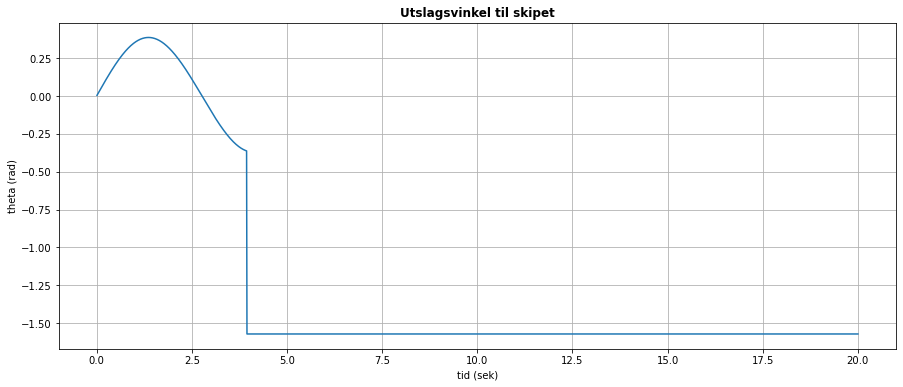

In [102]:
w0 = [0, lowestOmega, 0, yC,0, 0] #initialbetingelse (vektor)
tNumDiffEq7, wNumDiffEq7, checkCapsize = capsizeODESolver(diffEq7, t0, tEnd, w0, stepSize, rk4) 

plt.figure(figsize=(15,6)) #setter størrelse på plottet
plt.plot(tNumDiffEq7, wNumDiffEq7[:, 0]) #plotter som theta som en funksjon av tiden
plt.xlabel('tid (sek)') # tittel på x-aksen
plt.ylabel('theta (rad)') # tittel på y-akse
plt.title("Utslagsvinkel til skipet", fontweight= "bold") #tittel på plottet
plt.grid() #rutenett
plt.show() #aktiverer plottet

Den laveste $\omega_0$-verdien vi har fått med toleranse lik $10^{-3}$ er $0.44$. Her har vi også plottet med denne initialbetingelsen. Fra plottet ser vi at skipet kantrer fra omtrent $t=4 s$. 


Til nå har vi sett på et skip uten last. I et realistisk scenario vil vi antageligvis ha last på skipet.
Hvis nå inkluderer lastet på skipet får vi en litt annerledes dynamikk. Før vi kan se på hvordan lasten påvirker skipet må vi finne ligningene som beskriver vekselvirkningene. 

Vi har at dreiemomentet er gitt av:
$$\ddot{\theta} = -\frac{S_Lm_L}{I_C}g\cos{\theta}-\frac{F_Bh}{I_C}\sin{\theta}$$

Summen av kreftene på skipet fra lastet i x retning er:

$$\sum{F_x} = m_Lg\cos{\theta}\sin{\theta}$$

da blir summen på differensialform:

$$\frac{dv_x}{dt} = \frac{m_L}{m}g\cos{\theta}\sin{\theta}$$

i y retning:


$$\sum{F_y} =  -mg + A\sigma_0g -m_Lg\cos^2{\theta}$$ 

og på differensialform:



$$\frac{dv_y}{dt} = -g + \frac{A\sigma_0g}{m} -\frac{m_L}{m}g\cos^2{\theta}$$


La oss nå se på dynamikken til lastet langs dekket


$\sum{F}$ i likevekt på lasten:
$$\sum{F_y} = mg - N = 0 $$
$$N = mg$$

$$\sum{F_x} = 0$$

$\sum{F}$ ut av likevekt på lasten:
$$\sum{F_y} = -G_y + N $$

$$m_L\frac{d^2y}{dt^2} = -m_Lg\cos{\theta} + N$$
$$m_L\frac{d^2y}{dt^2} = -m_Lg\cos{\theta} + m_Lg\cos{\theta}$$
$$m_L\frac{d^2y}{dt^2} = 0$$


For x har vi følgende:  
  

$$\sum{F_x} = -G_x = m\frac{d^2s_L}{dt^2} = -mg\sin{\theta}$$
$$\frac{d^2s_L}{dt^2} = -g\sin{\theta}$$


Vi får da matrisen
$$\dot\theta = \omega$$
$$\ddot\theta = -\frac{S_Lm_L}{I_C}g\cos{\theta}-\frac{F_Bh}{I_C}\sin{\theta}$$
$$\dot{x} = v_x$$
$$\dot{y} = v_y$$
$$\dot{v_x} = \frac{m_L}{m}g\cos{\theta}\sin{\theta}$$
$$\dot{v_y} = -g + \frac{A\sigma_0g}{m} -\frac{m_L}{m}g\cos^2{\theta}$$
$$\dot{s_L} = v_L$$
$$\dot{v_L} = -g\sin{\theta}$$  



$$ \vec{f} = 
\begin{vmatrix}
\omega \\ -\frac{S_Lm_L}{I_C}g\cos{\theta}-\frac{F_Bh}{I_C}\sin{\theta} \\ v_x \\ v_y \\ \frac{m_L}{m}g\cos{\theta}\sin{\theta} \\  -g + \frac{A\sigma_0g}{m} -\frac{m_L}{m}g\cos^2{\theta} \\ v_L \\ -g\sin{\theta} \\
\end{vmatrix}$$


In [103]:
def fixedpointFunctionWithLoad(x):
    sigmaShipLoad = sigma*(1+0.001)
    sigmaFactorShipLoad = sigmaShipLoad*np.pi/sigma0
    return np.sin(x)+sigmaFactorShipLoad # gir beta for skip + last

#Forklaring av parametre:
# t: tidsarray
# w: vektor på formen w =[theta, omega, x-koord til MC, y-koord til MC, V_x til MC, V_y til MC, s_L koord til lasten, v_Lfarten til lastet]
def DiffShipLoad(t,w):
    fArray = np.zeros(8) # lager en fArray
    if abs(w[6]) > R: # ser om lastets posisjon er av båten 
        mL = 0 # når lastet er av settes massen til 0
        beta = fixedpoint(fixedpointFunction, radian0, tol=1.e-6, maxIter=40) # henter ny beta
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) - (Fb*h/(Ic))*np.sin(w[0]) # d(omega)/dt
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = 0 # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - 0  #d(v_y)/dt 
        fArray[6] = 0 #d(s_l)/dt 
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt 
    else:
        mL = 0.001*m # massen når lastet er på skipet
        beta = fixedpoint(fixedpointFunctionWithLoad, radian0, tol=1.e-6, maxIter=40) # henter ny beta
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) - (Fb*h/(Ic))*np.sin(w[0]) # d(omega)/dt
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = (mL/m)*g*np.cos(w[0])*np.sin(w[0]) # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2  #d(v_y)/dt 
        fArray[6] = w[7] #d(s_l)/dt 
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt 
                       
    return fArray

In [104]:
def fixedpointFunctionWithLoad(x):
    sigmaShipLoad = sigma*(1+0.08)
    sigmaFactorShipLoad = sigmaShipLoad*np.pi/sigma0
    return np.sin(x)+sigmaFactorShipLoad # gir beta for skip + last

#Her står 08 for at vi setter massen til lasten lik 0.08 * massen til skipet
#Forklaring av parametre:
# t: tidsarray
# w: vektor på formen w =[theta, omega, x-koord til MC, y-koord til MC, V_x til MC, V_y til MC, s_L koord til lasten, v_Lfarten til lastet]
def DiffShipLoad08(t,w):
    fArray = np.zeros(8) # lager en fArray

    if abs(w[6]) > R: # ser om lastets posisjon er av båten 
        mL = 0 # når lastet er av settes massen til 0
        beta = fixedpoint(fixedpointFunction, radian0, tol=1.e-6, maxIter=40) # henter ny beta
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -0 - (Fb*h/(Ic))*np.sin(w[0]) # d(omega)/dt
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = 0 # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - 0  #d(v_y)/dt
        fArray[6] = 0 #d(s_l)/dt 
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt 
    else:
        mL = 0.08*m # massen når lastet er på skipet
        beta = fixedpoint(fixedpointFunctionWithLoad, radian0, tol=1.e-6, maxIter=40) # henter ny beta
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) - (Fb*h/(Ic))*np.sin(w[0]) # d(omega)/dt
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = (mL/m)*g*np.cos(w[0])*np.sin(w[0]) # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2  #d(v_y)/dt 
        fArray[6] = w[7] #d(s_l)/dt
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt 
                       
    return fArray

For å studere hele dynamikken til skipet er vi nødt til å plotte for litt mer enn bare $\theta$ og $s_L$ (lastens posisjon). I tillegg ser vi bort fra kantringen for å studere dynamikken i sin helhet. Vi har valgt å plotte for massesenterets x- og y-posisjon, men kun for den tunge lasten siden fenomenet vi er interessert i kommer tydeligst frem ved denne massen.
I tillegg plotter vi x-posisjonen kun for deler av t, dette kommer av at x stiger mye mer enn y. Når lasten når endepunktet av skipet (falt av) så endres ikke $s_L$, samt vil $m_L$ lik $0$.

In [105]:
w0 = [0,0.2,0,yC,0,0,3,0] # initialbetingelser
t0 = 0 # starttid
tEnd = 40 # sluttid
tLoad001,wLoad001,checkCapsize = capsizeODESolver(DiffShipLoad, t0, tEnd, w0, stepSize, rk4)  # løser ODE med RK4 og gitt steglengde
tLoad08, wLoad08,checkCapsize = capsizeODESolver(DiffShipLoad08, t0, tEnd, w0, stepSize, rk4)  # løser ODE med RK4 og gitt steglengde
senterOfBoat = np.zeros(tEnd+1) # sentrum av dekket

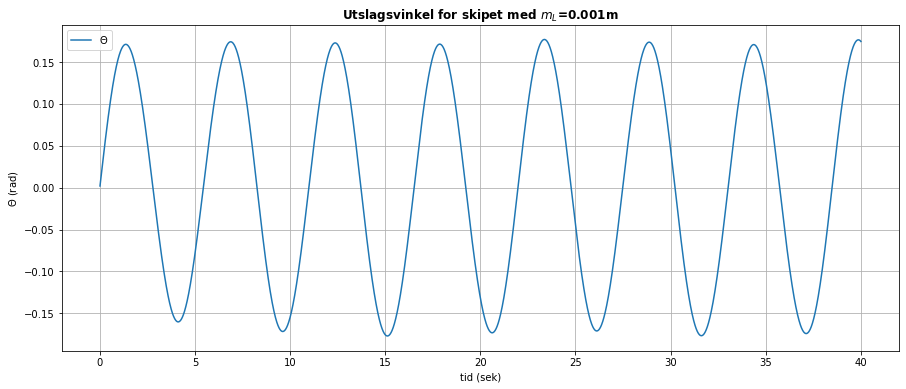

In [106]:
#plotting av m_l = 0.001
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoad001, wLoad001[:,0], label = "$\Theta$") # theta
plt.title("Utslagsvinkel for skipet med $m_{L}$=0.001m", fontweight= "bold") # tittel
plt.xlabel('tid (sek)') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.legend() #plasserer legend
plt.grid() # rutenett 
plt.show() #aktiverer plottet 

Fra plottet ser vi at utslagsvinkelen ikke endrer seg når lasten faller av. Dette kommer av at lastens masse er svært liten i forholdt skipets masse. Da blir bidraget neglisjerbart.

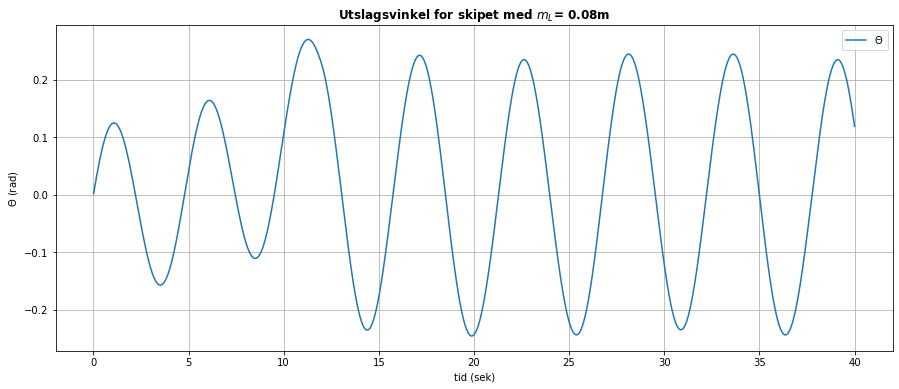

In [109]:
# plotting av m_L = 0.08m
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoad08, wLoad08[:,0],label = "$\Theta$") # theta
plt.title("Utslagsvinkel for skipet med $m_{L}$= 0.08m", fontweight= "bold") # tittel
plt.xlabel('tid (sek)') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.legend() # plasserer legend
plt.grid() # rutenett
plt.show() # aktiverer plottet

Fra plottene våre ser vi noen interessante fenomener. I plottet hvor lasten har større masse ser vi at vinkelutslaget er redusert og at det så stiger. Når lasten er på vil dreiemomentet styres av to krefter. Disse to kreftene er lastens tyngde og skipets oppdrift. Når lasten er av har vi kun oppdriften som bidrar. I tillegg reduserer massetettheten til skipet seg så bidraget blir større. Dette kommer av at massetettheten bestemmer vekten (m) til skipet. Denne massen (m) skalerer kreftene våres og da vil lavere masse gi mindre nedskalering. 

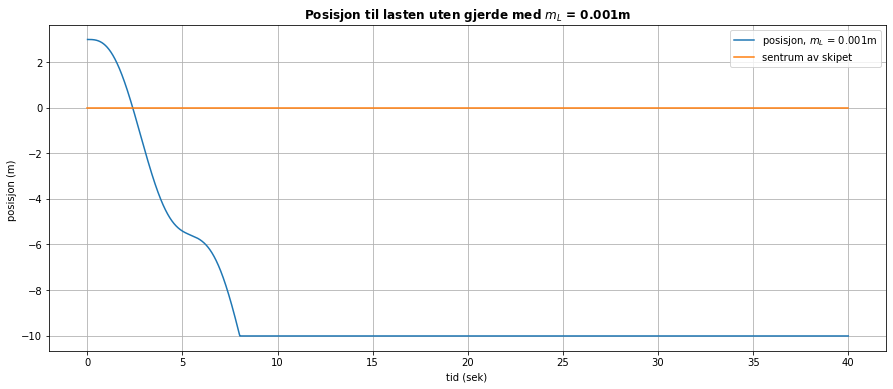

In [110]:
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoad001, wLoad001[:,6],label = "posisjon, $m_{L}$ = 0.001m") # posisjon til last m_L = 0.001m
plt.plot(senterOfBoat,label = "sentrum av skipet") # plotter sentrum av dekket
plt.title("Posisjon til lasten uten gjerde med $m_{L}$ = 0.001m", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('posisjon (m) ') # tittel på y-aksen
plt.legend() # plasserer legend
plt.grid() # rutenett
plt.show() # aktiverer plottet

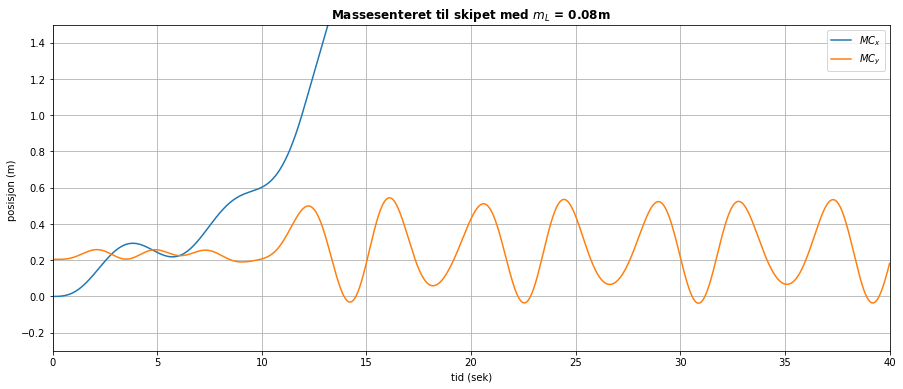

In [111]:
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoad08, wLoad08[:,2],label = "$MC_{x}$") # massesenterets x posisjon
plt.plot(tLoad08, wLoad08[:,3],label = "$MC_{y}$") # massesenterets y posisjon
plt.title("Massesenteret til skipet med $m_{L}$ = 0.08m", fontweight= "bold") # tittel
plt.xlabel('tid (sek)') # tittel på x-aksen
plt.ylabel('posisjon (m) ') # tittel på y-aksen
plt.ylim(-0.3,1.5) # setter min og max y verdier
plt.xlim(0,tEnd) # setter min og max x verdier
plt.legend() # plasserer legend
plt.grid() # rutenett
plt.show() # aktiverer plottet

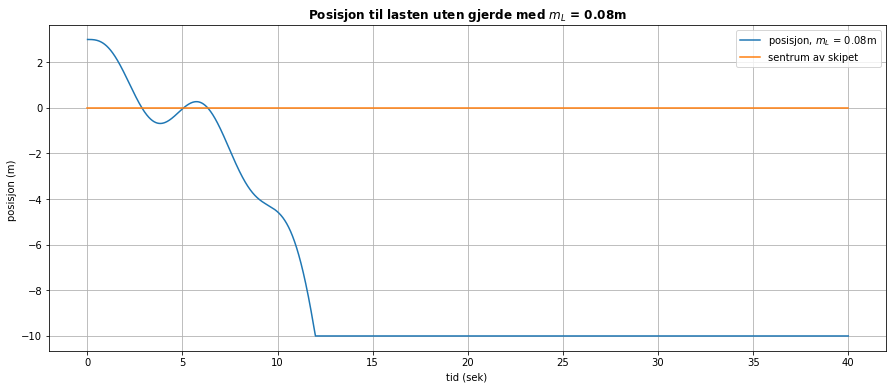

In [112]:
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoad08, wLoad08[:,6],label = "posisjon, $m_{L}$ = 0.08m")  # posisjon til last m_L = 0.08m
plt.plot(senterOfBoat,label = "sentrum av skipet") # plotter sentrum av dekket
plt.title("Posisjon til lasten uten gjerde med $m_{L}$ = 0.08m", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('posisjon (m) ') # tittel på y-aksen
plt.legend() # plasserer legend
plt.grid() # rutenett
plt.show() # aktiverer plottet

La oss først se på x-komponenten til massesenteret. Endringen i denne verdien kommer utelukkende fra lastens posisjon på dekket. For at det totale massesenteret skal forbli i sentrum og at impulsen skal holdes konstant når lasten beveger seg mot venstre, må skipet bevege seg mot høyre, men siden lasten veier mindre enn skipet trenger det ikke å bevege seg i motsatt retning like fort. Dette er da årsaken til grafen til x-posisjonen. 


Til slutt har vi y komponenten til skipet massesenter. I plottet begynner amplituden med å være liten og når lasten faller av får vi en stor endring i amplituden. Når lasten er av skipet utøver ikke lasten noe tyngde på skipet lenger og massetettheten til systemet reduseres. Vi får da en ny beta og det negative bidraget til lasten som utøver på skipet forsvinner. 

I virkeligheten ville man gjerne hatt et gjerde på skipet slik at lasten ikke faller av. I dette litt urealistiske tilfellet vil vi gjøre det slik at når lasten treffer gjerdet så vil den stoppe opp og feste seg til gjerdet. Når det er sagt så er fremdeles dette scenarioet interessant fordi vi får se hva som skjer med skipet når lasten befinner seg der lasten gir størst bidrag til dreiemomentet. Det er nøyaktig på R vi får lengst arm og dermed størst dreiemoment. 


Vi velger å ikke å se på x-posisjonen, da vi forventer at den skal være lik. Dette er en rimelig antagelse siden x-posisjonen til massesenteret avhenger av lastens posisjonen på $\underline{dekket}$.

In [123]:
#Her står 001 for at vi setter massen til lasten lik 0.001 * massen til skipet
def DiffShipLoadFence001(t,w):
    beta = fixedpoint(fixedpointFunction, radian0, tol=1.e-6, maxIter=40) # henter ny beta
    gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
    A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
    Fb = A*sigma0*g # oppdrift
    fArray = np.zeros(8) # matrise
    mL = 0.001*m # massen når lastet er på skipet
    if abs(w[6]) > R: # ser om lastets posisjon er av båten 
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) - (Fb*h/(Ic))*np.sin(w[0]) # d(omega)/dt
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = (mL/m)*g*np.cos(w[0])*np.sin(w[0]) # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2  #d(v_y)/dt 
        fArray[6] = 0  #d(s_l)/dt
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt
    else:
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) - (Fb*h/(Ic))*np.sin(w[0]) # d(omega)/dt
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = (mL/m)*g*np.cos(w[0])*np.sin(w[0]) # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2  #d(v_y)/dt
        fArray[6] = w[7] #d(s_l)/dt
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt
    
    return fArray

In [124]:
#Her står 08 for at vi setter massen til lasten lik 0.08 * massen til skipet
def DiffShipLoadFence08(t,w):
    beta = fixedpoint(fixedpointFunctionWithLoad, radian0, tol=1.e-6, maxIter=40) # henter ny beta
    gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
    A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
    Fb = A*sigma0*g # oppdrift
    fArray = np.zeros(8) # matrise
    mL = 0.08*m # massen når lastet er på skipet
    if abs(w[6]) > R: # ser om lastets posisjon er av båten 
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) - (Fb*h/(Ic))*np.sin(w[0]) # d/dt(omega)
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = (mL/m)*g*np.cos(w[0])*np.sin(w[0]) # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2  #d(v_y)/dt
        fArray[6] = 0  #d(s_l)/dt
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt
    else:
        fArray[0] = w[1] # d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) - (Fb*h/(Ic))*np.sin(w[0]) # d(omega)/dt
        fArray[2] = w[4] # d(x-koord)/dt
        fArray[3] = w[5] # d(y-koord)/dt
        fArray[4] = (mL/m)*g*np.cos(w[0])*np.sin(w[0]) # d(v_x)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2  #d(v_y)/dt
        fArray[6] = w[7] #d(s_l)/dt
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt 
    
    
    return fArray

In [125]:
w0 = [0,0.2,0,yC,0,0,3,0] # initialbetingelser
t0 = 0 # starttid
tEnd = 40 # sluttid
tLoadFence001,wLoadFence001,checkCapsize = capsizeODESolver(DiffShipLoadFence001, t0, tEnd, w0, stepSize, rk4)  # løser ODE med RK4 og gitt steglengde
tLoadFence08, wLoadFence08,checkCapsize = capsizeODESolver(DiffShipLoadFence08, t0, tEnd, w0, stepSize, rk4)  # løser ODE med RK4 og gitt steglengde
senterOfBoat = np.zeros(tEnd+1) # sentrum av dekket

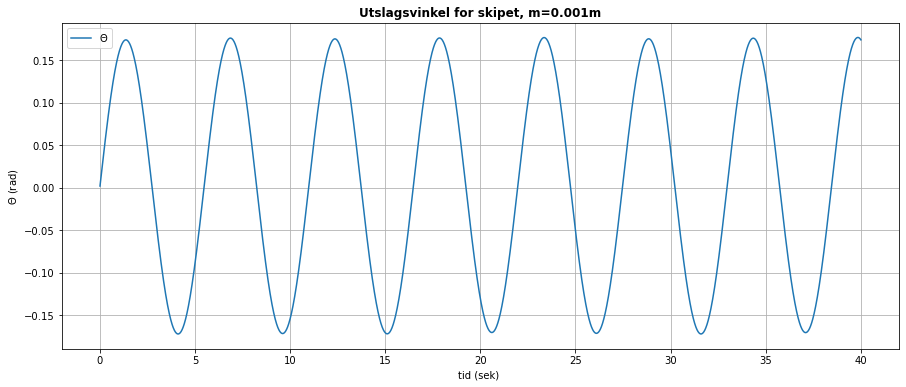

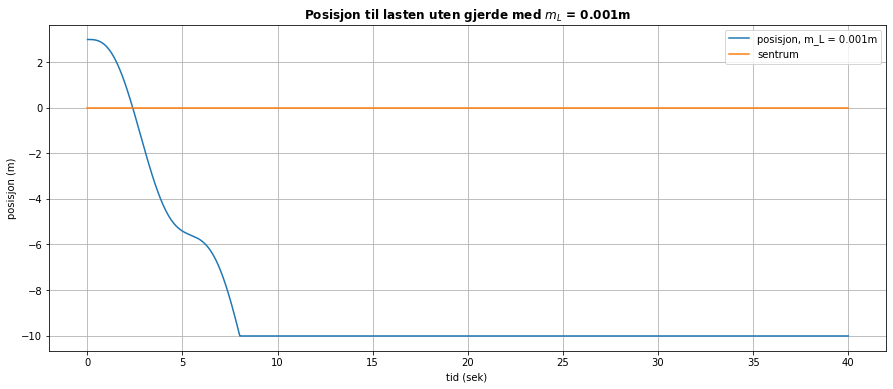

In [132]:
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoadFence001, wLoadFence001[:,0], label = "$\Theta$") # theta
plt.title("Utslagsvinkel for skipet, m=0.001m", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.legend() #plasserer legend 
plt.grid() # rutenett 

plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoad001, wLoad001[:,6],label = "posisjon, m_L = 0.001m") # posisjon til last m_L = 0.001m
plt.plot(senterOfBoat,label = "sentrum") # plotter sentrum av dekket
plt.title("Posisjon til lasten uten gjerde med $m_{L}$ = 0.001m", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('posisjon (m)') # tittel på y-akse
plt.legend() # plasserer legend
plt.grid() # rutenett
plt.show() # aktiverer plottet

Fra utslagsvinkel-plottet ser vi ingen merkbar endring. Dette kommer av samme årsaker som ble nevnt tidligere. Samme argumentasjon gjelder $s_L$-plottet.

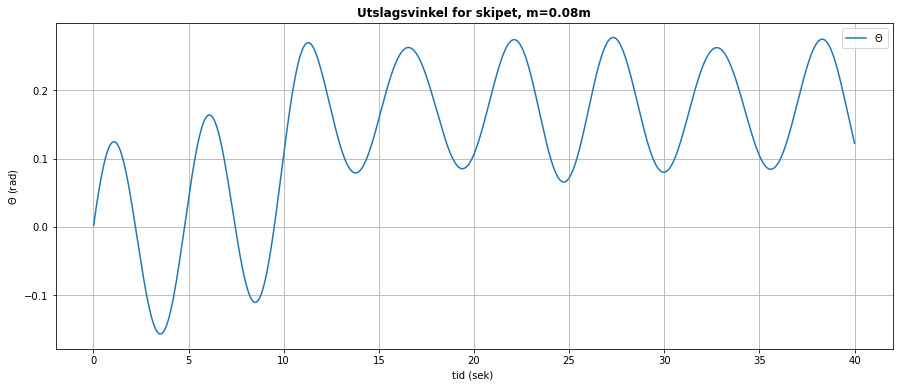

In [134]:
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoadFence08, wLoadFence08[:,0], label = "$\Theta$") # theta
plt.title("Utslagsvinkel for skipet, m=0.08m", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.legend() #plasserer legend
plt.grid() #rutenett 

Fra utslagsvinkel-plottet ser vi at theta oscillerer mellom positiv og negativt verdier i begynnelsen, når lasten treffer gjerdet ser vi en drastisk endring. Vinkelutslaget stopper å oscillere om $0$, likevektspunktet flytter seg slik at vinkelutslaget kun er i det positive området. Dette kommer av at dreiemomentet lasten utgjør på skipet avhenger av posisjonen til lasten, når posisjonen til lasten stopper å variere vil dreiemomentet bidraget være en konstant som forflytter likevektspunktet.

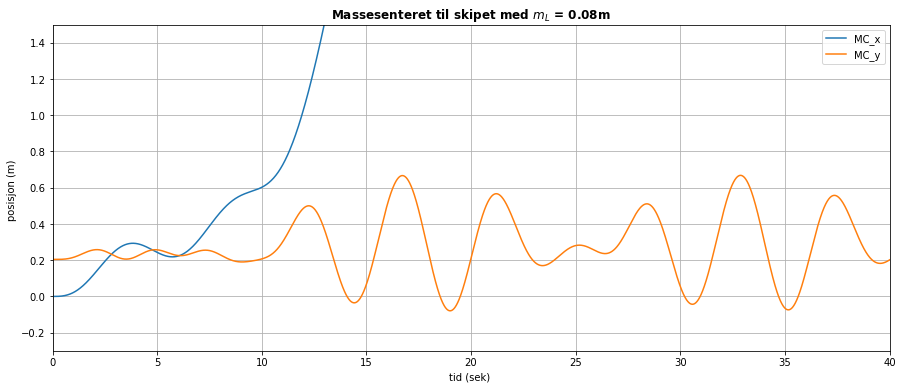

In [128]:
# plotting av m = 0.08m
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoadFence08, wLoadFence08[:,2],label = "MC_x") # massesenterets x posisjon
plt.plot(tLoadFence08, wLoadFence08[:,3],label = "MC_y") # massesenterets y posisjon
plt.title("Massesenteret til skipet med $m_{L}$ = 0.08m", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('posisjon (m) ') # tittel på y-aksen
plt.ylim(-0.3,1.5) # setter min og max y verdier
plt.xlim(0,tEnd) # setter min og max x verdier
plt.legend() # plasserer legend
plt.grid() # rutenett
plt.show() # aktiverer plottet

Nå har vi bare y komponenten igjen. Fra plottet ser vi nok engang at amplituden starter lavt og at den stiger når lasten befinner seg der den gir mest dreiemoment. Når dreiemomentet blir stort øker $\gamma$ og da vil også oppdriften øke. 
Kvalitativt sett kan vi forklare det ved at skipet vil bli dratt ned til den siden lasten befinner seg på. Og da øker tverrsnitt av skipet som befinner seg under vann og da øker oppdriftskraften.

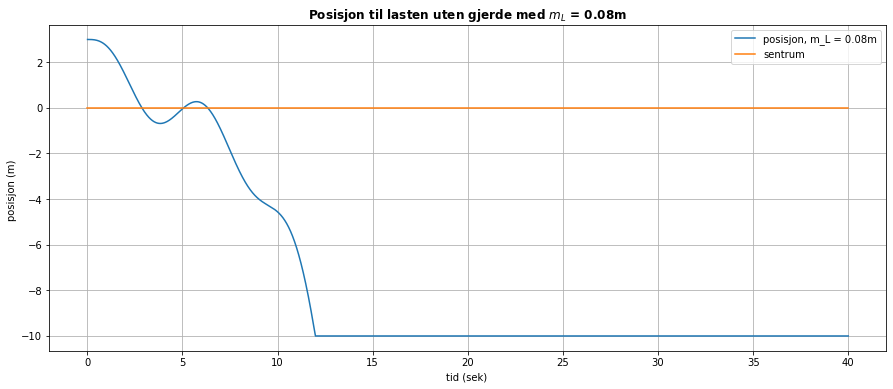

In [135]:
plt.figure(figsize=(15, 6)) # setter størrelse på plottet
plt.plot(tLoad08, wLoad08[:,6],label = "posisjon, m_L = 0.08m")  # posisjon til last m_L = 0.08m
plt.plot(senterOfBoat,label = "sentrum") # plotter sentrum av dekket
plt.title("Posisjon til lasten uten gjerde med $m_{L}$ = 0.08m", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('posisjon (m) ') # tittel på y-aksen
plt.legend() # plasserer legend
plt.grid() # rutenett
plt.show() # aktiverer plottet

Her ser vi at plottet for $s_L$ er uendret, fordi gjerdene ikke påvirker dynamikken til lasten.

Fram til nå har vi sett bort fra friksjon mellom vannet og skipets skrog. Vi ønsker å utforske hvordan dynamikken til skipet blir når vi inkluderer denne friksjonen. Dette betyr at vi må inkludere flere krefter i ligning ([6](#mjx-eqn-eq6)) og flere dreiemomenter i ligning ([5](#mjx-eqn-eq5)). 

Vi har at friksjonen gir oss en kraft $f = -k_fR\gamma\omega$ i x-retning, og et dreiemoment lik $\tau_f = f(y_C-(R(\cos(\gamma/2))-1))$.

Dermed får vi at summen av krefter i x-retning er lik:
$$\sum F = -k_fR\gamma\omega$$

og summen av dreiemomenter er lik:
$$\sum \tau = F_Bh\sin{\theta} + f(y_C-(R(\cos(\gamma/2))-1))$$

Vi får da den nye $\vec{f}$:
$$ \vec{f} = 
\begin{vmatrix}
\omega \\ -\frac{F_Bh\sin{\theta}}{I_C} + \frac{f(y_C-(R(\cos(\gamma/2))-1))}{I_C}\\ v_x \\ v_y \\ \frac{-k_fR\gamma\omega}{m} \\ -g + \frac{A\sigma_0g}{m}
\end{vmatrix}$$

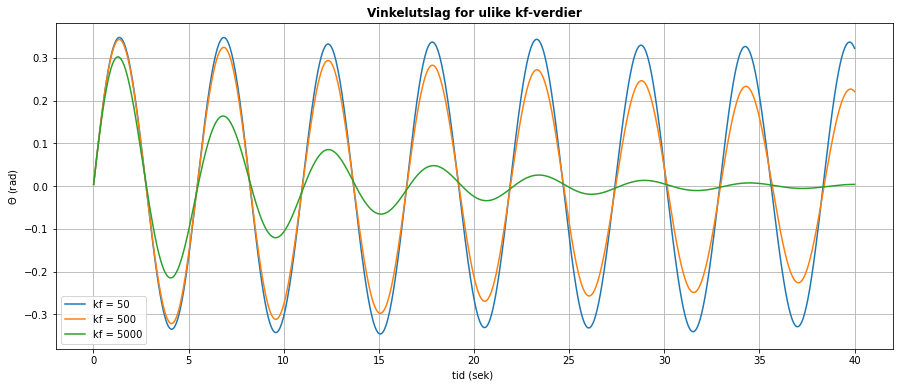

In [138]:
#I denne koden må vi endre fortegn på k_f da vi har definert positiv retning av kraft i x-retning motsatt av det
#oppgaveteksten har gjort. 

#Forklaring av parametre:
# t: tidsarray
# w: vektor på formen w =[theta, omega, x-koord til MC, y-koord til MC, V_x til MC, V_y til MC]
def frictionShip(t,w):
    #definerer parametre:
    gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) #vinkel mellom metasenter og vannet
    A = 1/2 * R**2 * (gamma - np.sin(gamma)) #mengden fortrengt vann
    Fb = A*sigma0*g #oppdrift
    
    fArray = np.zeros(6) #lager en tom array til å fylle med verdier
    fArray[0] = w[1] #d(theta)/dt
    fArray[1] = -(Fb*h/Ic)*np.sin(w[0]) + (kf*R*gamma*w[1]*(yC-(R*(np.cos(gamma/2)))-1))/Ic #d/dt(omega)
    fArray[2] = w[4] #d/dt(x-koord. til massesenter) --> farten til massesenteret i x-retning
    fArray[3] = w[5] #d/dt(y-koord. til massesenter) --> farten til massesenteret i y-retning
    fArray[4] = (kf*R*gamma*w[1])/m #d/dt(v i x-retning) --> akselerasjon til massesenter i x-retning
    fArray[5] = -g + (A*sigma0*g)/m  #d/dt(v i y-retning) --> akselerasjon til massesenter i y-retning
    return fArray


#initialbetingelser:
w0 = [0,0.4,0,yC,0,0] 
t0 = 0
tEnd = 40 #velger et passende tidsintervall


kfArray = [50, 500, 5000] #array over ulike kf-verdier

plt.figure(figsize=(15,6)) # setter størrelse på plottet
for kf in kfArray:
    #bruker capsize for å få med en eventuell kantring av båten:
    tfric,wfric,checkcapsize = capsizeODESolver(frictionShip, t0, tEnd, w0, stepSize, rk4)
  
    plt.plot(tfric, wfric[:,0], label = f"kf = {kf}") #plotter theta som en funksjon av tiden
    plt.title(f"Vinkelutslag for ulike kf-verdier", fontweight= "bold") # tittel
    plt.xlabel('tid (sek) ') # tittel på x-aksen
    plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
    plt.grid() #rutenett

plt.legend() #plasserer legend
plt.show() #aktiverer plottet

Her velger vi å plotte theta som en funksjon av tiden, da det er den verdien som er mest interessant å studere når vi skal undersøke skipets dynamikk. Fra plottet kan vi se at for større $k_f$ vil vi få at vinkelutslaget til skipet bli raskere dempet. Dette gir mening med intuisjonen, da en større friksjonskraft vil omgjøre mer av skipets bevegelsesenergi til varme. 

I tillegg til friksjon mellom skipets skrog og vannet, vil det i en realistisk situasjon også kunne oppstå bølger og vind. I dette tilfellet vil vi inkludere dette ved å introdusere en harmonisk horisontal rettet kraft på tvers av lengderetningen. 

Vi vil igjen være nødt til å legge til flere krefter i ligning ([6](#mjx-eqn-eq6)) og dreiemomenter i ligning ([5](#mjx-eqn-eq5)).
Den harmoniske horisontalt rettet kraften vil gi oss en kraft i x-retning $F_w = F_0\cos{\omega_w}t$ der $\omega_w = 0.93\omega_0$ og $\omega_0 = \sqrt{mgh/I_C}$.

I tillegg vil vi få et dreiemoment $T_w = F_wy_C$ der $F_w$ er gitt ovenfor.

Altså får vi at summen av krefter i x-retning:
$$\sum F = -k_fR\gamma\omega + F_0\cos{\omega_w}t$$

og summen av dreiemomenter er lik:
$$\sum \tau = F_Bh\sin{\theta} + f(y_C-(R(\cos(\gamma/2))-1)) + F_wy_C$$

Vi får igjen en ny $\vec{f}$:

$$ \vec{f} = 
\begin{vmatrix}
\omega \\ -\frac{F_Bh\sin{\theta}}{I_C} + \frac{f(y_C-(R(\cos(\gamma/2))-1))}{I_C} + \frac{F_wy_C}{I_C}\\ v_x \\ v_y \\ \frac{-k_fR\gamma\omega}{m} + \frac{F_0\cos{\omega_w}t}{m}\\ -g + \frac{A\sigma_0g}{m}
\end{vmatrix}$$


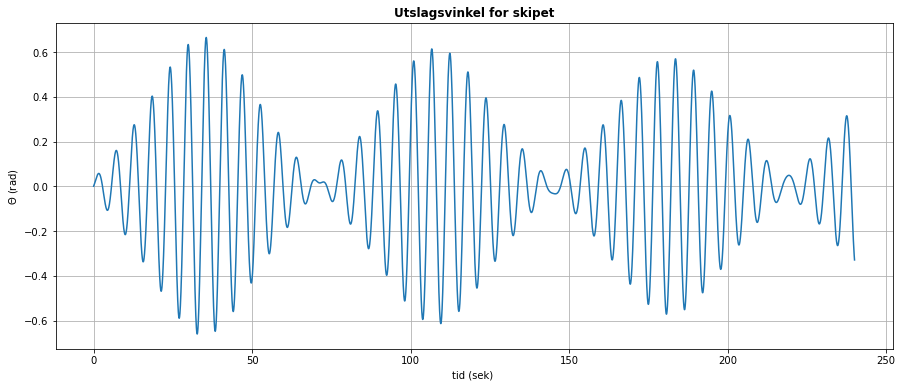

In [139]:
#I denne koden må vi endre fortegn på k_f da vi har definert positiv retning av kraft i x-retning motsatt av det
#oppgaveteksten har gjort. 

#Forklaring av parametre:
# t: tidsarray
# w: vektor på formen w =[theta, omega, x-koord til MC, y-koord til MC, V_x til MC, V_y til MC]
def frictionWaveShip(t,w):
    #definerer parametere:
    kf  = 100 #friksjonskoeffisient
    w_0 = np.sqrt((m*g*h)/Ic) #vinkelfrekvens til harmonisk oscillator
    w_w = 0.93*w_0 #vinkelfrekvens til den harmoniske kraften
    F_0 = 0.625*m*g #amplitude til den harmoniske kraften
    F_w = F_0*np.cos(w_w*t) #harmonisk horisontalt rettet kraft på tvers av lengderetningen
    gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) #vinkel mellom metasenter og vannet
    A = 1/2 * R**2 * (gamma - np.sin(gamma)) #mengden fortrengt vann
    Fb = A*sigma0*g #oppdrift
    fArray = np.zeros(6) #lager en tom array til å fylle med verdier
    fArray[0] = w[1] #d(theta)/dt
    fArray[1] = -(Fb*h/Ic)*np.sin(w[0]) + (kf*R*gamma*w[1]*(w[3]-(R*(np.cos(gamma/2)))-1))/Ic + (F_w*w[3])/Ic #d(omega)/dt
    fArray[2] = w[4] #d(x-koord. til massesenter)/dt
    fArray[3] = w[5] #d(y-koord. til massesenter)/dt
    fArray[4] = (kf*R*gamma*w[1])/m + (F_0*np.cos(w_w*t))/m #d(v i x-retning)/dt 
    fArray[5] = -g + (A*sigma0*g)/m #d(v i y-retning)/dt
    return fArray


w0 = [0,np.radians(2),0,yC,0,0] #initialbetingelser
t0 = 0 #starttid
tEnd = 240 #sluttid

#bruker capsize for å få med en eventuell kantring av båten:
tfric,wfric = odeSolver(frictionWaveShip, t0, tEnd, w0, stepSize, rk4)

#plotter vinkelutslaget til båten:
plt.figure(figsize=(15,6)) # setter størrelse på plottet
plt.plot(tfric, wfric[:,0])
plt.title("Utslagsvinkel for skipet", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.grid() #rutenett
plt.show() #aktiverer plottet 

Vi ser at skipet får svevning i vinkelutslaget sitt når vi legger til den harmoniske kraften gitt av bølger og vind. Dette kan forklares ved at vi får interferens mellom to bølger med nesten samme frekvens. Da vil bølgene vekselvis interferere destruktivt og konstruktivt. Den resulterende bølgeamplituden vil variere med frekvensen lik halve differansen mellom de to bølgefrekvensene. De to frekvensene som er nesten like blir i vårt tilfelle vinkelfrekvensen til skipet ($\theta$) og vinkelfrekvensen til den harmoniske krafta ($\omega_w$). Likevel kan vi se at amplituden til den resulterende bølgen vil minske med tiden. Dette kan forklares med friksjonskraften som virker mot bevegelsen til skipet.


I denne delen av rapporten har vi til nå hovedsakelig brukt RK4 som metode for å løse differensialligningene våre. Det kan være interessant å innføre en ny metode for å løse de samme differensialene. Det følger både med ulemper og fordeler med andre metoder og det skal vi ta en nærmere titt på nå.  

Bogacki-Shampine er en metode innenfor Runge-Kutta. Den er av orden tre og bruker fire steg med FSAL-egenskap (First Same As Last). Så den bruker tre funksjonsevalueringer per steg. Forskjellen mellom Bogacki-Shampine og RK4 er orden. Som sagt har RK4 orden 4. Fordelen med å bruke en lavere ordens metode er at den vil gå raskere enn metoder med høyere orden. Men en ulempe vil være at vi får mindre nøyaktige løsninger med en høyere ordens metode. 

In [145]:
#Forklaring av parametre:
# f = diffligningen vi skal løse 
# t0 = starttid 
# tEnd = sluttid 
# w0 = initialbetingelser 
# stepSize = lengde mellom tn og tn+1
# tolBogShamp = toleranse for å godta et steg
# p = pessimistfaktor
def odeBogShamp(f, t0, tEnd, w0, stepSize0, tolBogShamp, p):
    w = np.array([w0]) 
    t = np.array([t0])

    tn = t0 #initialverdi 
    wn = w0 #initialverdi
    stepSize = stepSize0 
    maxcall = 100000 #Maximum allowed calls of method
    ncall = 0 #antall kjøringer gjennom while-løkka
    
    k1 = f(tn, wn) 
    while tn < tEnd - 1.e-10: 
        k2 = f(tn+1/2 * stepSize, wn+1/2 * stepSize*k1)
        k3 = f(tn+3/4 * stepSize, wn+3/4 * stepSize*k2)
        wTry = wn + 2/9 * stepSize*k1 + 1/3 *stepSize*k2 + 4/9 *stepSize*k3
        k4 = f(tn+stepSize, wTry)
        zNext = wn + 7/24 *stepSize*k1 + 1/4 *stepSize*k2 + 1/3 *stepSize*k3 + 1/8 *stepSize*k4
        tTry = tn + stepSize
        errorEstimate = np.linalg.norm(wTry-zNext)
        # Justerer steglengden slik at vi når tEnd
        if tn + stepSize > tEnd:                   
            stepSize = tEnd - tn 
        
        ncall = ncall + 1
        
        if errorEstimate <= tolBogShamp: #hvis dette er sant så skal steget aksepteres
            tn = tTry    
            wn = wTry
            # Lagre verdiene  
            w = np.concatenate((w, np.array([wn])))
            t = np.append(t, tn)
            k1 = k4 #FSAL
        
        # else: Steget blir avvist og ingenting skal skje
        
        # Justerer steglengden
        stepSize = p*(tolBogShamp/errorEstimate)**(1/(3))*stepSize

        # Stopper hvis loopen har kjørt maksimal antall ganger
        if ncall > maxcall:
            return t, w

    return t, w

Fra koden over ser man at vi har valgt å bruke en adaptiv Bogacki-Shampine metode. Det vil si at vi kontinuerlig sjekker den lokale feilen for å avgjøre størrelsen på steglengden. Men det at vi bruker en adaptiv metode vil skape et problem. Dette problemet er at får ulik total antall steg sammenlignet med RK4. Dette kommer av at den adaptive metoden vår justerer steglengden slik at vi ikke får tatt like mange steg som ved RK4. 

In [146]:
def controlWithoutFence(t,w):
    fArray = np.zeros(8) 
    kf  = 50 #friksjonskoeffisient
    w_0 = np.sqrt((m*g*h)/Ic) #vinkelfrekvens til harmonisk oscillator
    w_w = 0.93*w_0 #vinkelfrekvens til den harmoniske kraften
    F_0 = 0.3*m*g #amplitude til den harmoniske kraften
    F_w = F_0*np.cos(w_w*t) #harmonisk horisontalt rettet kraft på tvers av lengderetningen
    if abs(w[6]) > R: # ser om lastets posisjon er av båten 
        mL = 0 # når lastet er av settes massen til 0
        beta = fixedpoint(fixedpointFunction, radian0, tol=1.e-6, maxIter=40) # henter ny beta
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] #d(theta)/dt
        fArray[1] =  0 -(Fb*h/Ic)*np.sin(w[0]) + (kf*R*gamma*w[1]*(w[3]-(R*(np.cos(gamma/2)))-1))/Ic + (F_w*w[3])/Ic #d(omega)/dt
        fArray[2] = w[4] #d(x-koord. til massesenter)/dt
        fArray[3] = w[5] #d(y-koord. til massesenter)/dt
        fArray[4] = (kf*R*gamma*w[1])/m + (F_0*np.cos(w_w*t))/m  + 0 #d(v i x-retning)/dt
        fArray[5] = -g + (A*sigma0*g)/m - 0 #d(v i y-retning) /dt
        fArray[6] = 0 #d(s_l)/dt 
        fArray[7] = 0 #d(v_l)/dt 
    else:
        mL = 0.08*m
        beta = fixedpoint(fixedpointFunctionWithLoad, radian0, tol=1.e-6, maxIter=40)
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] #d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) -(Fb*h/Ic)*np.sin(w[0]) + (kf*R*gamma*w[1]*(w[3]-(R*(np.cos(gamma/2)))-1))/Ic + (F_w*w[3])/Ic #d(omega)/dt
        fArray[2] = w[4] #d(x-koord. til massesenter)/dt
        fArray[3] = w[5] #d(y-koord. til massesenter)/dt
        fArray[4] = (kf*R*gamma*w[1])/m + (F_0*np.cos(w_w*t))/m + (mL/m)*g*np.cos(w[0])*np.sin(w[0]) #d(v i x-retning)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2 #d(v i y-retning)/dt 
        fArray[6] = w[7] #d(s_l)/dt 
        fArray[7] = -g*np.sin(w[0]) #d(v_l)/dt
    return fArray

Antall steg gjort i Bog er 5387
Antall steg gjort i RK4 er 24000


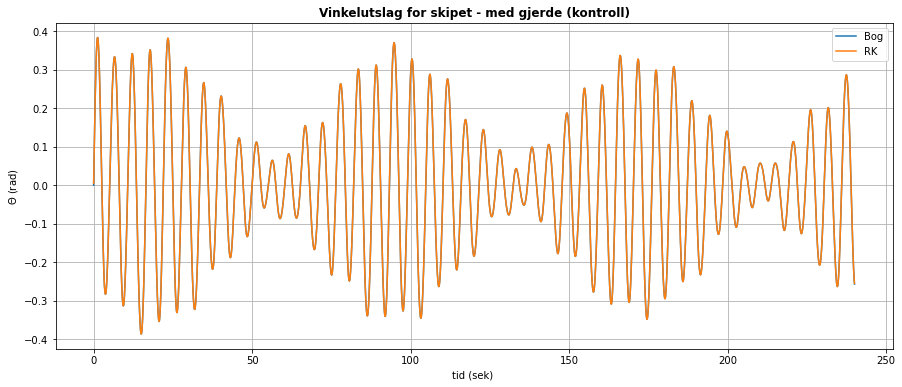

In [151]:
#initialbetingelser
w0 = [0,0.5,0,yC,0,0,3,0]
t0 = 0
tEnd = 240

#bruker capsize for å få med en eventuell kantring av båten:
tFricAndFenceBog, wFricAndFenceBog, capBog = capsizeODESolver(controlWithoutFence, t0, tEnd, w0, stepSize, "odeBogShamp")
tFricAndFenceRK, wFricAndFenceRK, capRK = capsizeODESolver(controlWithoutFence, t0, tEnd, w0, stepSize, rk4)

#ser på antall steg tatt av de ulike metodene
print(f"Antall steg gjort i Bog er {len(tFricAndFenceBog)}")
print(f"Antall steg gjort i RK4 er {len(tFricAndFenceRK)}")

plt.figure(figsize=(15,6)) #størrelse på plottet
plt.plot(tFricAndFenceBog,wFricAndFenceBog[:,0],label = "Bog") 
plt.plot(tFricAndFenceRK,wFricAndFenceRK[:,0], label = "RK")
plt.title("Vinkelutslag for skipet - med gjerde (kontroll)", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.legend()
plt.grid() #rutenett
plt.show() #aktiverer plottet

Total antall steg som tas av RK4 er 24000 og for Bogacki-Shampine er det 5387 steg. Men dette avhenger av en rekke betingelser. For RK4 så vil betingelsen være tidsintervallet. Men for Bogacki-Shampine så vil det også variere basert på steglengden. Det vil si vår adaptive funksjon tar ca ⅕ av stegene - noe som i seg selv er en stor fordel. Vi kommer oss rundt dette problem ved å se på feilen i ekstremalpunktene. Dette gjør vi i to plot slik at det er mulig å se hvilke plot som er maxima eller minima.

In [152]:
#Forklaring av parametre:
#sign: bestemmer om vi skal finne bunn- eller toppunkt
#w: løsning av diffligning
def extremaArray(w,sign): #finner ekstremalpunkt til en funksjon
    if sign == "min": #hvis vi skriver min ser vi etter minima 
        extremaIndex = (np.diff(np.sign(np.diff(w[:,0]))) > 0).nonzero()[0] + 1  #finner indeksene til lokal minima
    elif sign == "max": #hivs vi skriver max ser vi etter maxima
        extremaIndex = (np.diff(np.sign(np.diff(w[:,0]))) < 0).nonzero()[0] + 1  #finner indeksene til lokal maksima
        
    extremaVal = np.zeros(len(extremaIndex)) #tom array for extremalverider
    j = 0
    for i in extremaIndex: #itererer gjennom indexene
        extremaVal[j] = w[i,0] #fyller inn maxima eller minima
        j+=1 #indks
        
    return extremaVal

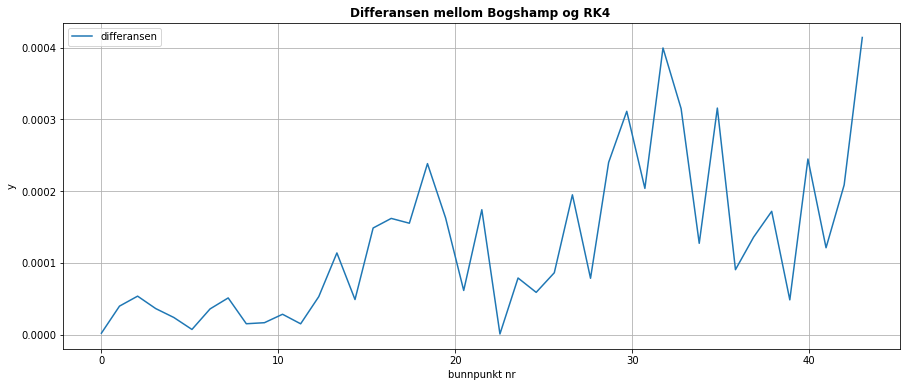

In [153]:
bogExtrema = extremaArray(wFricAndFenceBog,"min") #finner bunnpunktene for Bogacki-Shampine 
RK4Extrema = extremaArray(wFricAndFenceRK,"min") #finner bunnpunktene for RK4

diffExtremas = abs(bogExtrema-RK4Extrema) #finner avstanden mellom bog og RK4
tExtrema = np.linspace(0,len(diffExtremas),len(diffExtremas)) #lager en tarray

plt.figure(figsize=(15,6)) #størrelse på plottet
plt.plot(tExtrema,diffExtremas, label = "differansen")
plt.title("Differansen mellom Bogshamp og RK4 ", fontweight= "bold") #tittel på plottet
plt.xlabel("bunnpunkt nr") #titel på x-aksen
plt.ylabel("y") #titel på y-aksen
plt.legend() #plasserer legend
plt.grid() #rutenett
plt.show() #aktiverer plottet

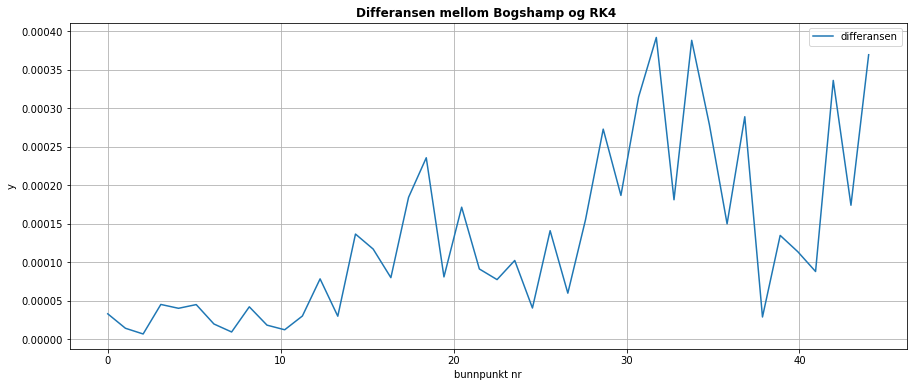

In [154]:
bogExtrema = extremaArray(wFricAndFenceBog,"max") #finner toppunkt for Bogacki-Shampine 
RK4Extrema = extremaArray(wFricAndFenceRK,"max") #finner toppunkt for RK4

diffExtremas = abs(bogExtrema-RK4Extrema) #finner avstanden mellom bog og RK4
tExtrema = np.linspace(0,len(diffExtremas),len(diffExtremas)) #lager en tarray

plt.figure(figsize=(15,6)) #størrelse på plottet
plt.plot(tExtrema,diffExtremas, label = "differansen") #plotter differanse
plt.title("Differansen mellom Bogshamp og RK4 ", fontweight= "bold") #tittel på plottet
plt.xlabel("bunnpunkt nr") #titel på x-aksen
plt.ylabel("y") #titel på y-aksen
plt.legend() #plasserer legend
plt.grid() #rutenett
plt.show() #aktiverer plottet

Fra plottene våre ser vi en generell trend hvor feilen øker med tiden. Dette skjer fordi RK4 og Bogacki-Shampine har ulike konvergensordener og har derfor ulik grad av presisjon. Siden de to metodene har ulik grad av presisjon vil de divergere fra hverandre og differansen vil derfor øke. Når det er sagt ser vi tilfeller hvor differansen plutselig blir liten igjen, disse tilfellene kommer av at vår adaptive løser har valgt en veldig god steglengde slik at feilen i dette tilfelle er svært liten. 

I realiteten vil det virke flere krefter på lasten enn det vi har hatt til nå. En kraft vi hittil har neglisjert er friksjonskraften mellom lasten og underlaget. Denne kraften vil ha en innvirkning på bevegelsen til lasten, som igjen vil påvirke bevegelsen til skipet. 

Bruker man realistiske tall og situasjoner, vil man i vårt tilfelle ha en friksjonskoeffisient på omtrent $0.2$  (Wikipedia, 2022). Da har vi tatt utgangspunkt i at både lasten og skipet er laget av tre, og at det er en regnfull dag så både dekket og lasten er våte. 

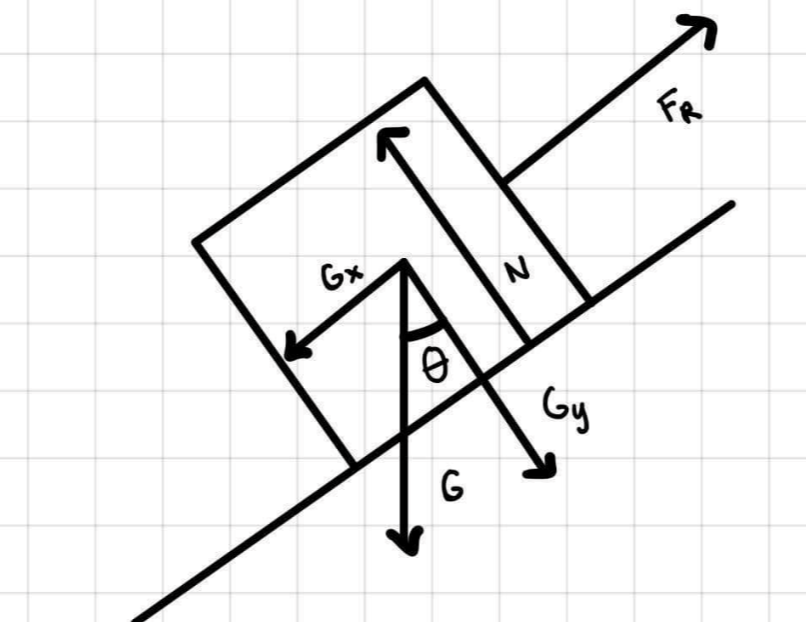

La oss ta en nærmere titt på hva slags krefter som fungerer på lasten når vi har med friksjon mellom dekket og lasten. 


Kreftene tegnet inn i figuren ovenfor gir oss fortsatt $\sum F_y = 0$. I x-retning vil vi få en annen sum av krefter enn tidligere. I x-retning får vi:
$$\sum F_x = F_R - G_x$$

Der:

$$G_x = mg\sin{\theta} $$

og 

$$F_R = \mu N = \mu G_y = \mu mg\cos{\theta}$$

Dermed har vi at summen av krefter på lasten:

$$\sum F =\mu mg\cos{\theta} - mg\sin{\theta}$$

Vi vil i teorien ha et dreiemoment på lasten som vil ha en påvirkning på massesenteret til skipet. Denne vil imidlertid være så liten at den kan neglisjeres.

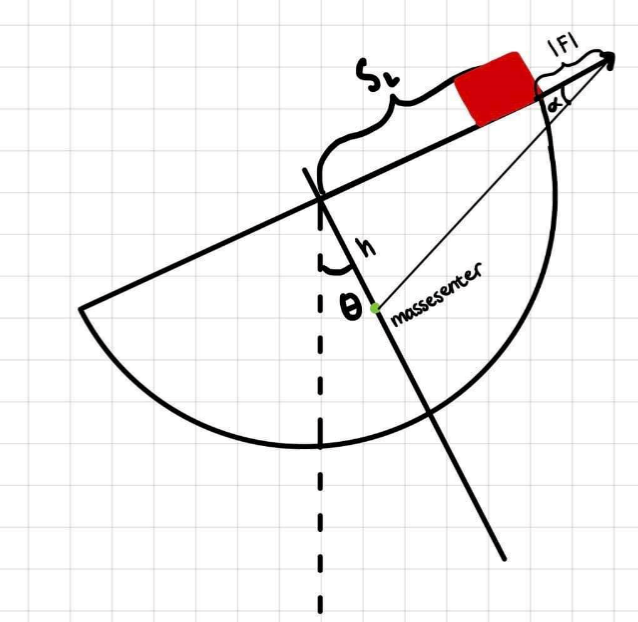

For å vise at dette dreiemomentet er såpass lite har vi valgt å regne det ut. Vi får at:


$$\tau_{frik} = \vec{R} x \vec{F} = |R||F|\sin{\alpha}$$


Fra figuren ser vi at:

$$|R| = \sqrt{h^2 + (S_L + |F|)^2}$$

I tillegg har vi at:

$$\alpha = \arctan{\frac{h}{S_L + |F|}}$$

Dermed har vi at dreiemomentet er gitt ved:

$$I\ddot{\theta} = \sqrt{h^2 + (S_L + |F|)^2} |F| \sin(\arctan{\frac{h}{S_L + |F|}})$$

Videre maksimerer vi tallverdiene får vi at den maksimale $\ddot\theta$ er av størrelsesorden $10^{-4}$ som vil si at den ikke vil ha noen signifikant innvirkning på massesenteret. I tillegg vil vi neglisjere kraften som virker på skipet fra lasten (motkraften til friksjonskraften), da denne også vil være minimal. Dermed vil vi i koden vår nå kun legge til et ekstra ledd i akselerasjonen til lasten, friksjon mellom havet og skipet, og den harmoniske krafta fra vind og bølger. 

Siden vi ønsker å implementere friksjon mellom lasten og skipet trenger vi å lage en modell for måten friksjonskoeffisienten oppfører seg. Det er spesielt viktig at produktet til friksjonskoeffisienten og normalkrafta er lik x-komponenten av legemets tyngde når vinkelen er under en spesifikk kritisk verdi. Vinkelen ($\Theta$) det er snakk om er den mellom underlaget og skråplanet som vi ser på figuren nedenfor. 

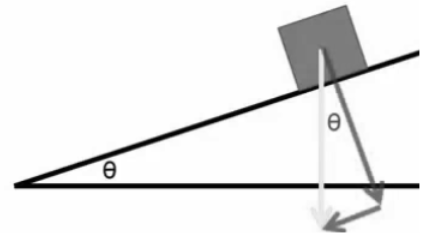

Hvis friksjonskraften er for stor vil vi få en retardasjon hvor legemet vil begynne å gli opp skråplanet. Om friksjonskraften ikke er lik påført kraft på legemet får vi akselerasjon slik at legemet beveger seg nedover skråplanet. Dette er problematisk fordi friksjonskraften avhenger av påført kraft på legemet. 

For å lage modellen av friksjonskoeffisienten har vi funnet en verdi for friksjon som gjelder for våt tre mot våt tre. Den statiske friksjonskoeffisienten bruker vi som max verdi og vi lar friksjonskoeffisienten øke lineært til den når denne verdien. Funksjonen stopper å øke når den når den kritiske verdien er oppnådd, denne verdien er arctan av statisk friksjonskoeffisient som blir 11 grader eller 0.2 rad. Etter denne kritiske verdien får vi en kinetisk friksjonskoeffisient som nok en gang er basert på våt tre mot våt tre. Denne verdien er 0.067 (Wikipedia, 2022). Vi regner ut stigningstallet til den lineære halvdelen ved å se at $\Theta$ befinner seg i det intervallet hvor lineær approksimasjon stemmer godt. Her kan vi bruke samme argumentasjon som vi gjorde for sin(x) og x. Da vil stigningstallet se ut som \Tan($\Theta$) eller bare $\Theta$.

In [157]:
def frictioncoefficient(theta,myStatic,myKinetic):
    if abs(theta) > np.arctan(myStatic): #sjekker om objektet flytter på seg
        return np.tan(theta) #statisk my 
    else:
        return myKinetic 
    
def frictionWaveLoadShipWithoutFence(t,w):
    fArray = np.zeros(8)
    kf  = 50 #friksjonskoeffisient
    w_0 = np.sqrt((m*g*h)/Ic) #vinkelfrekvens til harmonisk oscillator
    w_w = 0.93*w_0 #vinkelfrekvens til den harmoniske kraften
    F_0 = 0.3*m*g #amplitude til den harmoniske kraften
    F_w = F_0*np.cos(w_w*t) #harmonisk horisontalt rettet kraft på tvers av lengderetningen
    myStatic = 0.2
    myKinetic = 0.067
    
    if abs(w[6]) > R: # ser om lastets posisjon er av båten 
        mL = 0 # når lastet er av settes massen til 0
        beta = fixedpoint(fixedpointFunction, radian0, tol=1.e-6, maxIter=40) # henter ny beta
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] #d(theta)/dt
        fArray[1] =  0 -(Fb*h/Ic)*np.sin(w[0]) + (kf*R*gamma*w[1]*(w[3]-(R*(np.cos(gamma/2)))-1))/Ic + (F_w*w[3])/Ic #d(omega)/dt
        fArray[2] = w[4] #d(x-koord. til massesenter)/dt
        fArray[3] = w[5] #d(y-koord. til massesenter)/dt
        fArray[4] = (kf*R*gamma*w[1])/m + (F_0*np.cos(w_w*t))/m  + 0 #d(v i x-retning)/dt
        fArray[5] = -g + (A*sigma0*g)/m - 0 #d(v i y-retning)/dt
        fArray[6] = 0 #d(s_l)/dt 
        fArray[7] = 0 #d(v_l)/dt 
    else:
        mL = 0.08*m
        beta = fixedpoint(fixedpointFunctionWithLoad, radian0, tol=1.e-6, maxIter=40)
        gamma = 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(w[0])) + (w[3]-yC)/R) # vinkel mellom metasenter og vannet
        A = 1/2 * R**2 * (gamma - np.sin(gamma)) # mengden fortrengt vann
        Fb = A*sigma0*g # oppdrift
        fArray[0] = w[1] #d(theta)/dt
        fArray[1] = -w[6]*mL*g/Ic*np.cos(w[0]) -(Fb*h/Ic)*np.sin(w[0]) + (kf*R*gamma*w[1]*(w[3]-(R*(np.cos(gamma/2)))-1))/Ic + (F_w*w[3])/Ic #d(omega)/dt
        fArray[2] = w[4] #d(x-koord. til massesenter)/dt
        fArray[3] = w[5] #d(y-koord. til massesenter)/dt
        fArray[4] = (kf*R*gamma*w[1])/m + (F_0*np.cos(w_w*t))/m + (mL/m)*g*np.cos(w[0])*np.sin(w[0]) #d(v i x-retning)/dt
        fArray[5] = -g + (A*sigma0*g)/m - (mL/m)*g*np.cos(w[0])**2#d(v i y-retning)/dt
        fArray[6] = w[7] #d(s_l)/dt 
        fArray[7] = -g*np.sin(w[0])+g*frictioncoefficient(w[0],myStatic,myKinetic)*np.cos(w[0]) #d(v_l)/dt 
                       
    return fArray

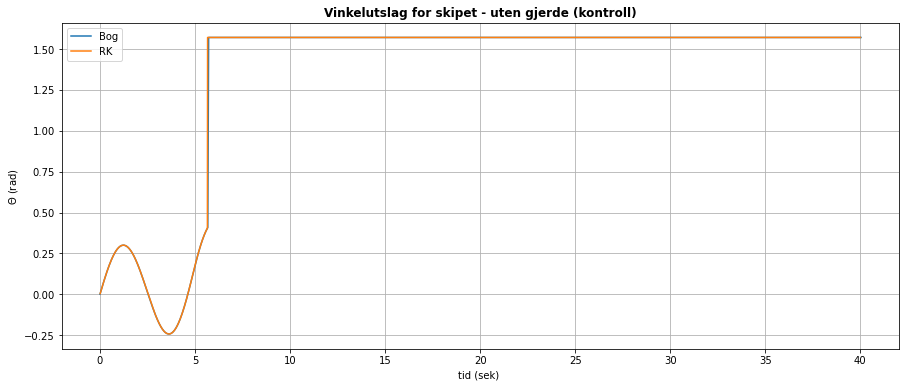

Kontroll
Her er tiden kantringen skjer 5.670745273826256 for Bogshamp
kantring skjer ved 23.39599133772317 for Bogshamp
Her er tiden kantringen skjer 5.649999999999924 for RK4
kantring skjer ved 23.17176444815931 for Rk4


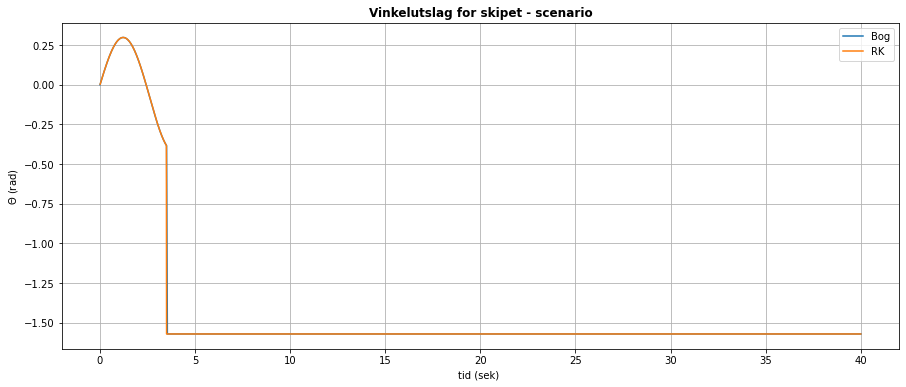

Scenario
Her er tiden kantringen skjer 3.501572770471032 for Bogshamp
Kantring skjer ved -22.014162804237003 for Bogshamp
Her er tiden kantringen skjer 3.4899999999999696 for RK4
Kantring skjer ved -21.88969166756038 for Rk4


In [160]:
#initialbetingelser
w0 = [0,0.4,0,yC,0,0,3,0]
t0 = 0
tEnd = 40
deltaOmega = 1
omega0 = 0
tControlWithoutFenceBog, wControlWithoutFenceBog, capBog = capsizeODESolver(controlWithoutFence, t0, tEnd, w0, stepSize, "odeBogShamp")
tControlWithoutFenceRK, wControlWithoutFenceRK, capRK = capsizeODESolver(controlWithoutFence, t0, tEnd, w0, stepSize, rk4)

plt.figure(figsize=(15,6)) #størrelse på plottet
plt.plot(tControlWithoutFenceBog,wControlWithoutFenceBog[:,0],label = "Bog")
plt.plot(tControlWithoutFenceRK,wControlWithoutFenceRK[:,0], label = "RK")
plt.title("Vinkelutslag for skipet - uten gjerde (kontroll)", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.legend() #plasserer legend
plt.grid() #rutenett
plt.show() #aktiverer plottet

print("Kontroll")
thetaIndexCap = np.argwhere(abs(wControlWithoutFenceBog[:,0])==np.pi/2) #finner index ved kantring for kontoll med bogshamp
print("Her er tiden kantringen skjer", tControlWithoutFenceBog[thetaIndexCap[0]-1][0],"for Bogshamp")#printer tid
print("kantring skjer ved",wControlWithoutFenceBog[thetaIndexCap[0]-1,0][0]*180/np.pi,"for Bogshamp")#printer vinkel


thetaIndexCap = np.argwhere(abs(wControlWithoutFenceRK[:,0])==np.pi/2) #finner index ved kantring for kontoll med Rk4
print("Her er tiden kantringen skjer", tControlWithoutFenceRK[thetaIndexCap[0]-1][0],"for RK4")#printer tid
print("kantring skjer ved",wControlWithoutFenceRK[thetaIndexCap[0]-1,0][0]*180/np.pi,"for Rk4")#printer vinkel


tFallOffBog, wFallOffBog, capBog = capsizeODESolver(frictionWaveLoadShipWithoutFence, t0, tEnd, w0, stepSize, "odeBogShamp")
tFallOffRK, wFallOffRK, capRK = capsizeODESolver(frictionWaveLoadShipWithoutFence, t0, tEnd, w0, stepSize, rk4)

plt.figure(figsize=(15,6)) #størrelse på plottet
plt.plot(tFallOffBog,wFallOffBog[:,0],label = "Bog")
plt.plot(tFallOffRK,wFallOffRK[:,0], label = "RK")
plt.title("Vinkelutslag for skipet - scenario", fontweight= "bold") # tittel
plt.xlabel('tid (sek) ') # tittel på x-aksen
plt.ylabel('$\Theta$ (rad)') # tittel på y-akse
plt.legend() #plasserer legend
plt.grid() #rutenett
plt.show() #aktiverer plottet

print("Scenario")
thetaIndexCap = np.argwhere(abs(wFallOffBog[:,0])==np.pi/2) #finner index ved kantring for kontoll med bogshamp
print("Her er tiden kantringen skjer", tFallOffBog[thetaIndexCap[0]-1][0],"for Bogshamp")#printer tid
print("Kantring skjer ved",wFallOffBog[thetaIndexCap[0]-1,0][0]*180/np.pi,"for Bogshamp")#printer vinkel


thetaIndexCap = np.argwhere(abs(wFallOffRK[:,0])==np.pi/2) #finner index ved kantring for kontoll med Rk4
print("Her er tiden kantringen skjer", tFallOffRK[thetaIndexCap[0]-1][0],"for RK4")#printer tid
print("Kantring skjer ved",wFallOffRK[thetaIndexCap[0]-1,0][0]*180/np.pi,"for Rk4")#printer vinkel

Her har vi plottet for det tilfellet der lasten kan falle av skipet. Vi har valgt å plotte for dette scenarioet, da dette er en mer realistisk situasjon, enn at vi har med gjerder uten en bremsekraft. Over dette plottet har vi valgt å plotte en “kontrollsituasjon” for å sammenligne. Denne kontrollsituasjon innebærer de samme kreftene bortsett fra friksjonskraften mellom lasten og underlaget. 


Vi ser at i kontrollsituasjonen vår oppstår kantring omtrent ved t = 5.6. I scenarioet med friksjon skjer kantringen litt tidligere ved ca t = 3.5. Grunnen til at skipet kantrer tidligere når det er friksjonen mellom lasten og skipet, er fordi at lasten nå beveger seg tregere. Når lasten befinner seg på positiv side av massesenteret, vil vi få en lengre periode med et negativt dreiemoment, kontra om vi ikke har friksjon mellom lasten og underlaget. Dette vil igjen føre til en høyere vinkelhastighet. Dermed vil vi med friksjon mellom lasten og underlaget kunne observere kantring tidligere enn uten.

## Konklusjon

I denne rapporten har vi tatt for oss hvordan ulike faktorer spiller inn på dynamikken og stabiliteten til skipet. Først fant vi vinkelen (beta) ved likevekt. Her testet vi ut to ulike metoder: halveringsmetoden og fikspunktmetoden. Her så vi på fordeler og ulemper med begge metodene. Det som skiller disse to er at halveringsmetoden er mer robust, og at fikspunktmetoden er raskere. Videre fant vi diffligningene som beskriver stabiliteten til skipet. Her har vi studert ulike metoder på å løse diffligninger. Metodene vi brukte var Euler, fjerde ordens Runge-Kutta og adaptiv Bogacki-Shampine. For Euler og RK4 så vi at den logaritmiske skalaen endra differansefunksjonen til en lineære funksjon. Fra dette fant vi konvergensordenen til metodene. Differansen i RK4 hadde et flatt området hvor avrundingen i dataene tillot ikke feilen å minke, som er svært nyttig å vite. Dette betyr i praksis at om vi velger en steglengde i dette flate intervallet får vi så godt som maskin nøyaktighet i resultatene våres. Vi har også undersøkt hvor god små vinkel approksimasjon er. Dette stemmer veldig godt for vinkler under 0.2 radianer. 

Vi har sett på diffligninger som beskriver et koblet system, og løst dette ved hjelp av RK4. Deretter har vi sett på hvordan varierende fortrengt vann påvirker massesenteret. Dette er fordi $\gamma$ alltid vil være større enn $\beta$. Videre fant vi den laveste omegaen som kunne gi oss kantring av skipet ved visse initialbetingelser. Denne verdien var $0.44$. I tillegg hadde vi med en friksjonskraft og en harmonisk kraft. Disse kreftene ga opphav til dempende svevning. Et fenomen hvor to relativt like frekvenser gir konstruktiv og destruktiv interferens, men som over tid blir mindre og mindre siden litt og litt av energien omgjøres til varme. Tilslutt satte vi på en last på skipet. Her undersøkte vi dynamikken til skipet, ved å studere hvordan x- og y-komponentene til massesenteret varierte. Vi kunne forklare bevegelsen til x-komponenten på grunn av bevarelse av massesenter og impuls. Bevegelsen til y-komponenten avhenger av tyngden til lasten. I tillegg vil y-komponenten stige i verdi når lasten faller av. Når vi så på mer realistiske scenarioer med friksjon mellom lasten og skipet fant vi ut at kantringen skjedde tidligere. Dette kom av at lasten bevegde seg sakte og var lengre på siden lasten starter på som da vil forårsake et dreiemoment som kantrer skipet. Dermed ser vi at effekten av å introdusere friksjon gir omtrent $2$ sekunder tidligere kantring, samt reduseres kantringsvinkelen med $1$ grad.

### Kildeliste 
Wikipedia. (2022, March 12). Friction. Retrieved 03 13, 2022,  
from Wikipedia: https://en.wikipedia.org/wiki/Friction